# ClusTabNet Demo Inference
Notebook này chạy demo mô hình trên 10 ảnh từ tập Validation và hiển thị ma trận kề dự đoán.

In [1]:
import sys
# Cài đặt chính xác vào môi trường Python đang chạy kernel này
!{sys.executable} -m pip install opencv-python matplotlib scipy tqdm numpy

print("Installation complete. If you still see errors, please RESTART THE KERNEL (Kernel -> Restart).")

Installation complete. If you still see errors, please RESTART THE KERNEL (Kernel -> Restart).



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob

try:
    import cv2
except ImportError:
    print("Lỗi import cv2. Hãy đảm bảo bạn đã Restart Kernel sau khi cài đặt.")
    raise

from model import ClusTabNetPipeline, ClusTabEmbedding
# IMPORT THÊM visualize_table_combined
from visualize import preprocess_input, visualize_table_combined

# ================= CONFIGURATION =================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAL_JSON_DIR = "dataset/pubtables_mini_test/data_ocr/val"
VAL_IMG_DIR = "dataset/pubtables_mini_test/images/val"
MODEL_PATH = "model/model_weitghloss_10epoch.pth"
VOCAB_PATH = "vocab.json"
MAX_SAMPLES = 10

print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
# 1. Load Vocabulary & Model
if os.path.exists(VOCAB_PATH):
    with open(VOCAB_PATH, "r", encoding='utf-8') as f:
        vocab = json.load(f)
    print(f"Vocab loaded: {len(vocab)} words")
else:
    print("Warning: vocab.json not found! Using empty dict.")
    vocab = {}

# Init Model
model = ClusTabNetPipeline(
    embedding_module=ClusTabEmbedding(vocab_size=len(vocab)+100, d_model=640),
    d_model=640, n_head=5, num_layers=3
)

if os.path.exists(MODEL_PATH):
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict, strict=False)
    print("Model checkpoint loaded successfully!")
else:
    print("Model checkpoint NOT found. Exploring random weights.")

model.to(DEVICE)
model.eval();

Vocab loaded: 174536 words
Model checkpoint loaded successfully!


In [4]:
# 2. Helper Function to Plot Matrices (Heatmaps)
def plot_prediction_matrices(img, matrices, num_real_words, img_name):
    """
    Vẽ ảnh gốc và 5 ma trận kề (Heatmaps)
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Ảnh gốc
    axes[0].imshow(img)
    axes[0].set_title(f"Original: {img_name}")
    axes[0].axis('off')
    
    task_names = ['same_row', 'same_col', 'same_header', 'same_cell', 'extract_cell']
    labels = ['Row Matrix', 'Col Matrix', 'Header Matrix', 'Cell Matrix', 'Spanning Matrix']
    
    for i, task in enumerate(task_names):
        ax = axes[i + 1]
        
        if task in matrices:
            # Lấy phần ma trận thực (bỏ padding)
            mat = matrices[task][:num_real_words, :num_real_words]
            
            im = ax.imshow(mat, cmap='viridis', vmin=0, vmax=1)
            ax.set_title(f"{labels[i]} ({num_real_words}x{num_real_words})")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.text(0.5, 0.5, "N/A", ha='center')
            
    plt.tight_layout()
    plt.show()

Found 10 samples to visualize.

[1/10] Heatmaps for: PMC1087493_table_2


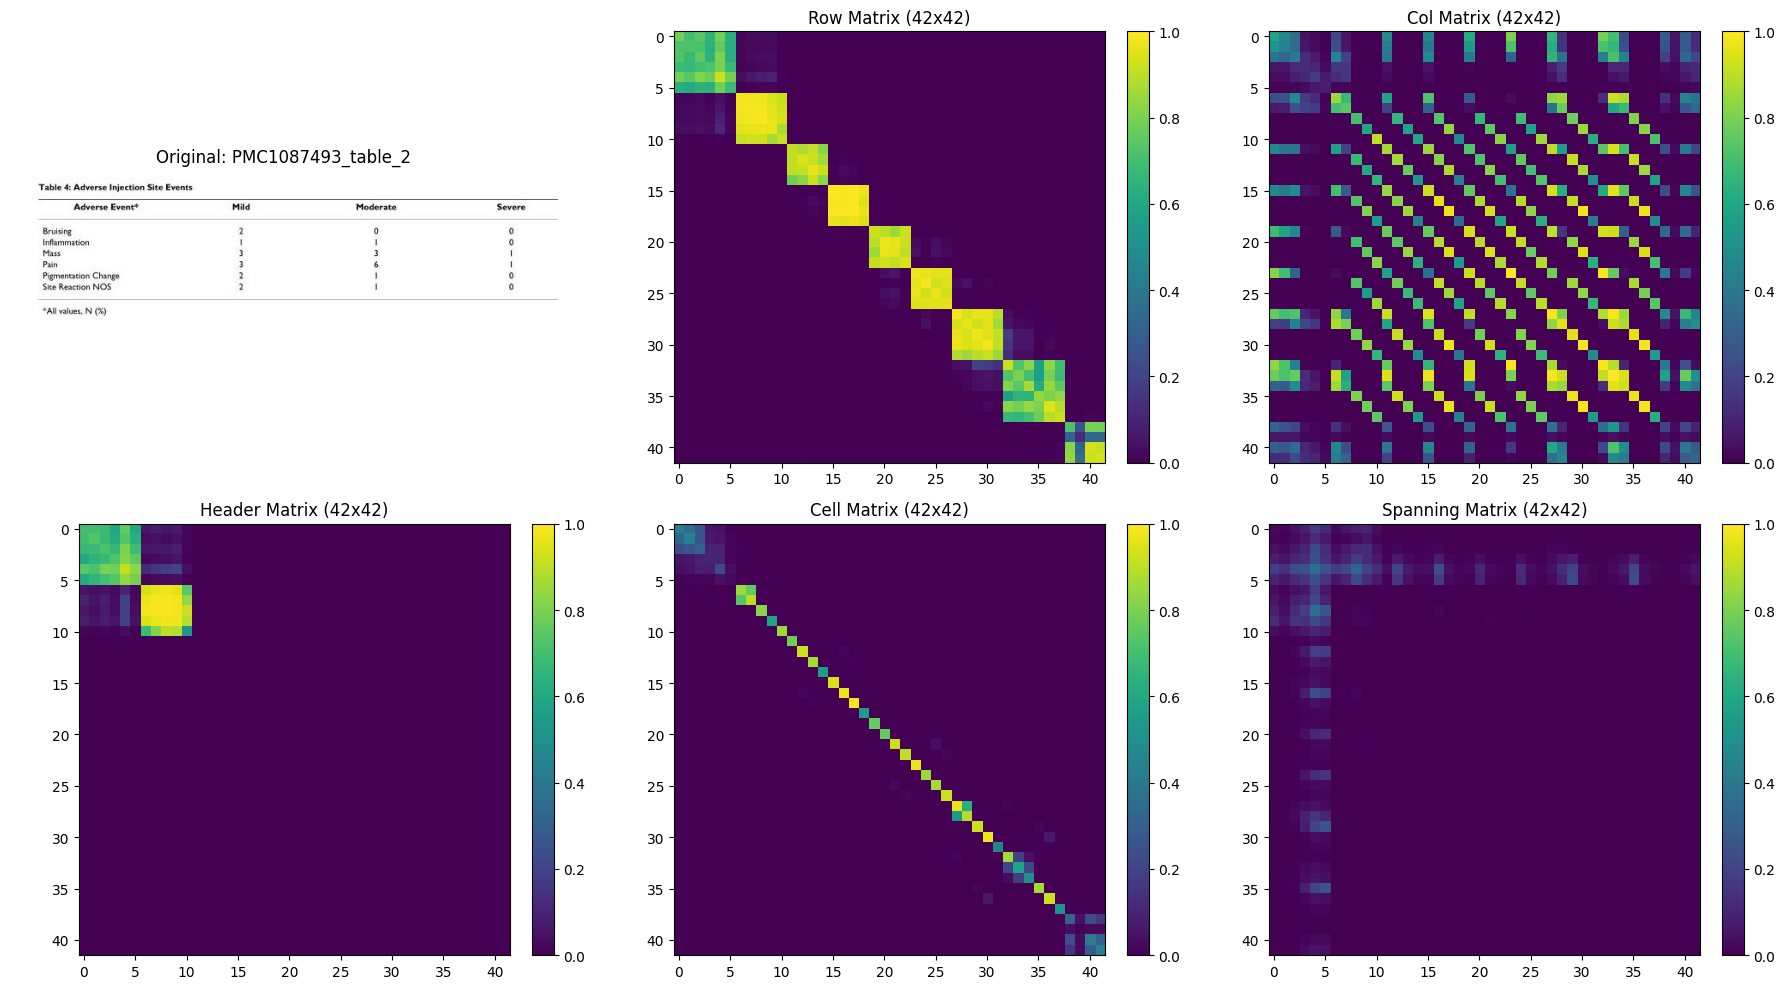

[2/10] Heatmaps for: PMC1180465_table_2


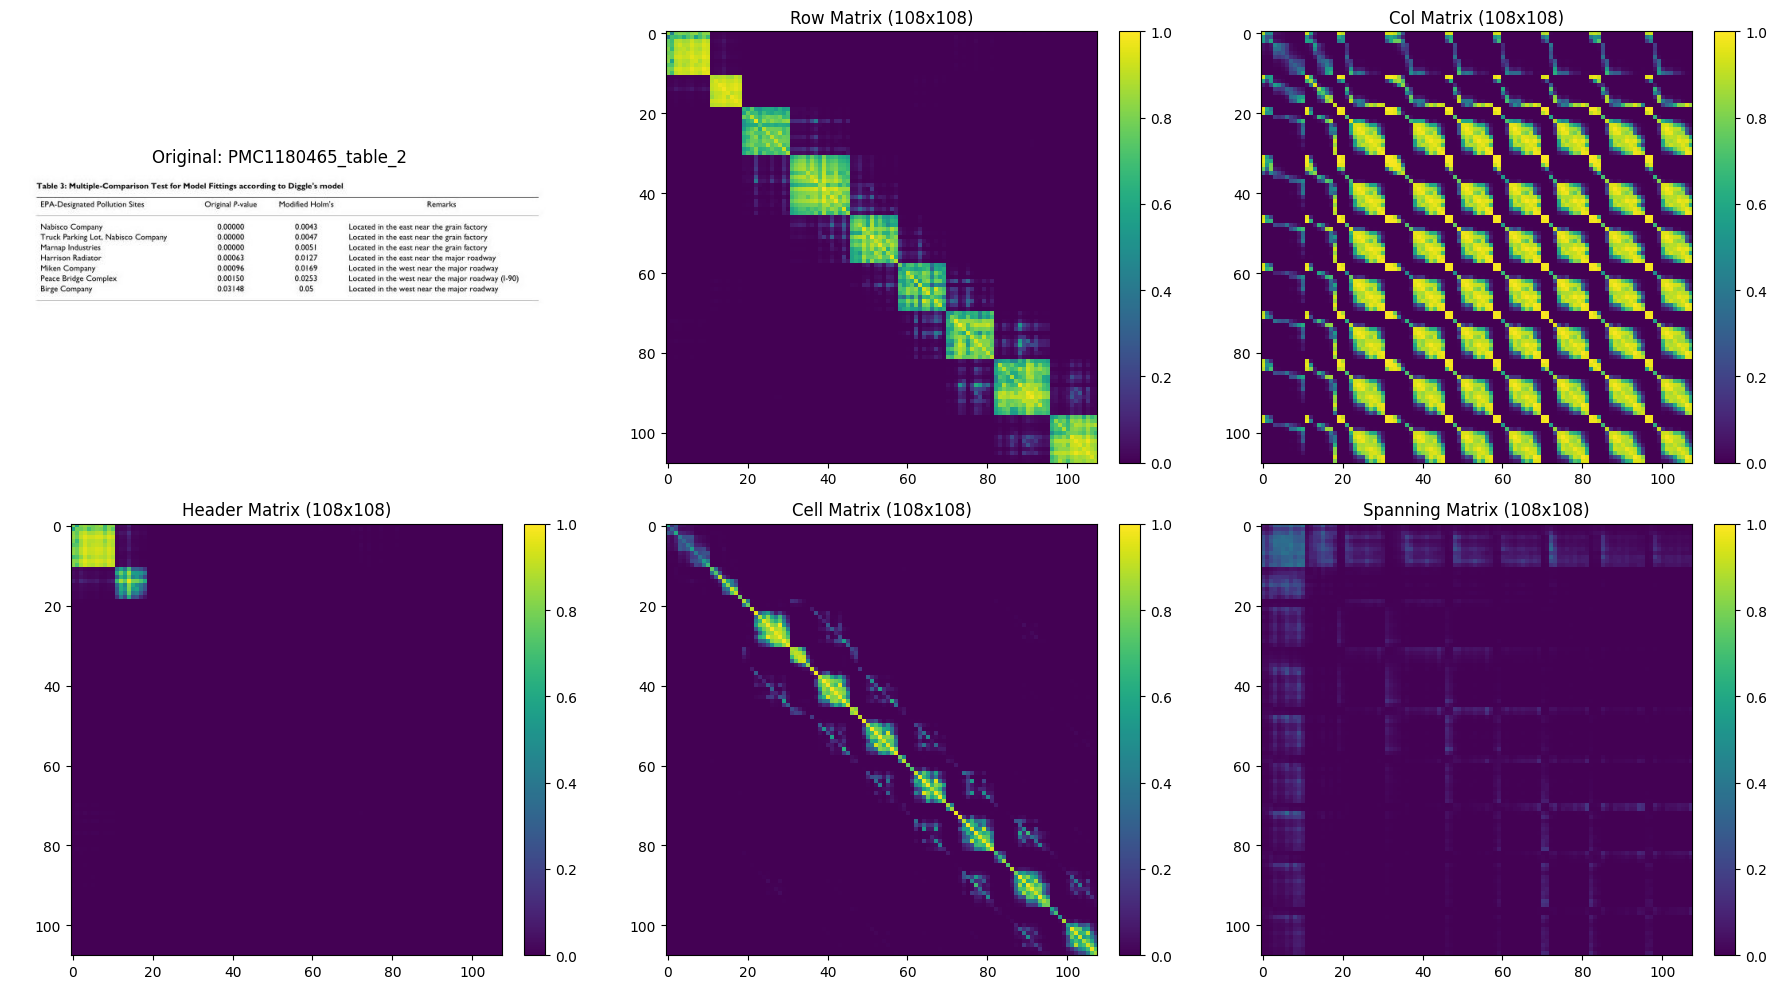

[3/10] Heatmaps for: PMC1198232_table_0


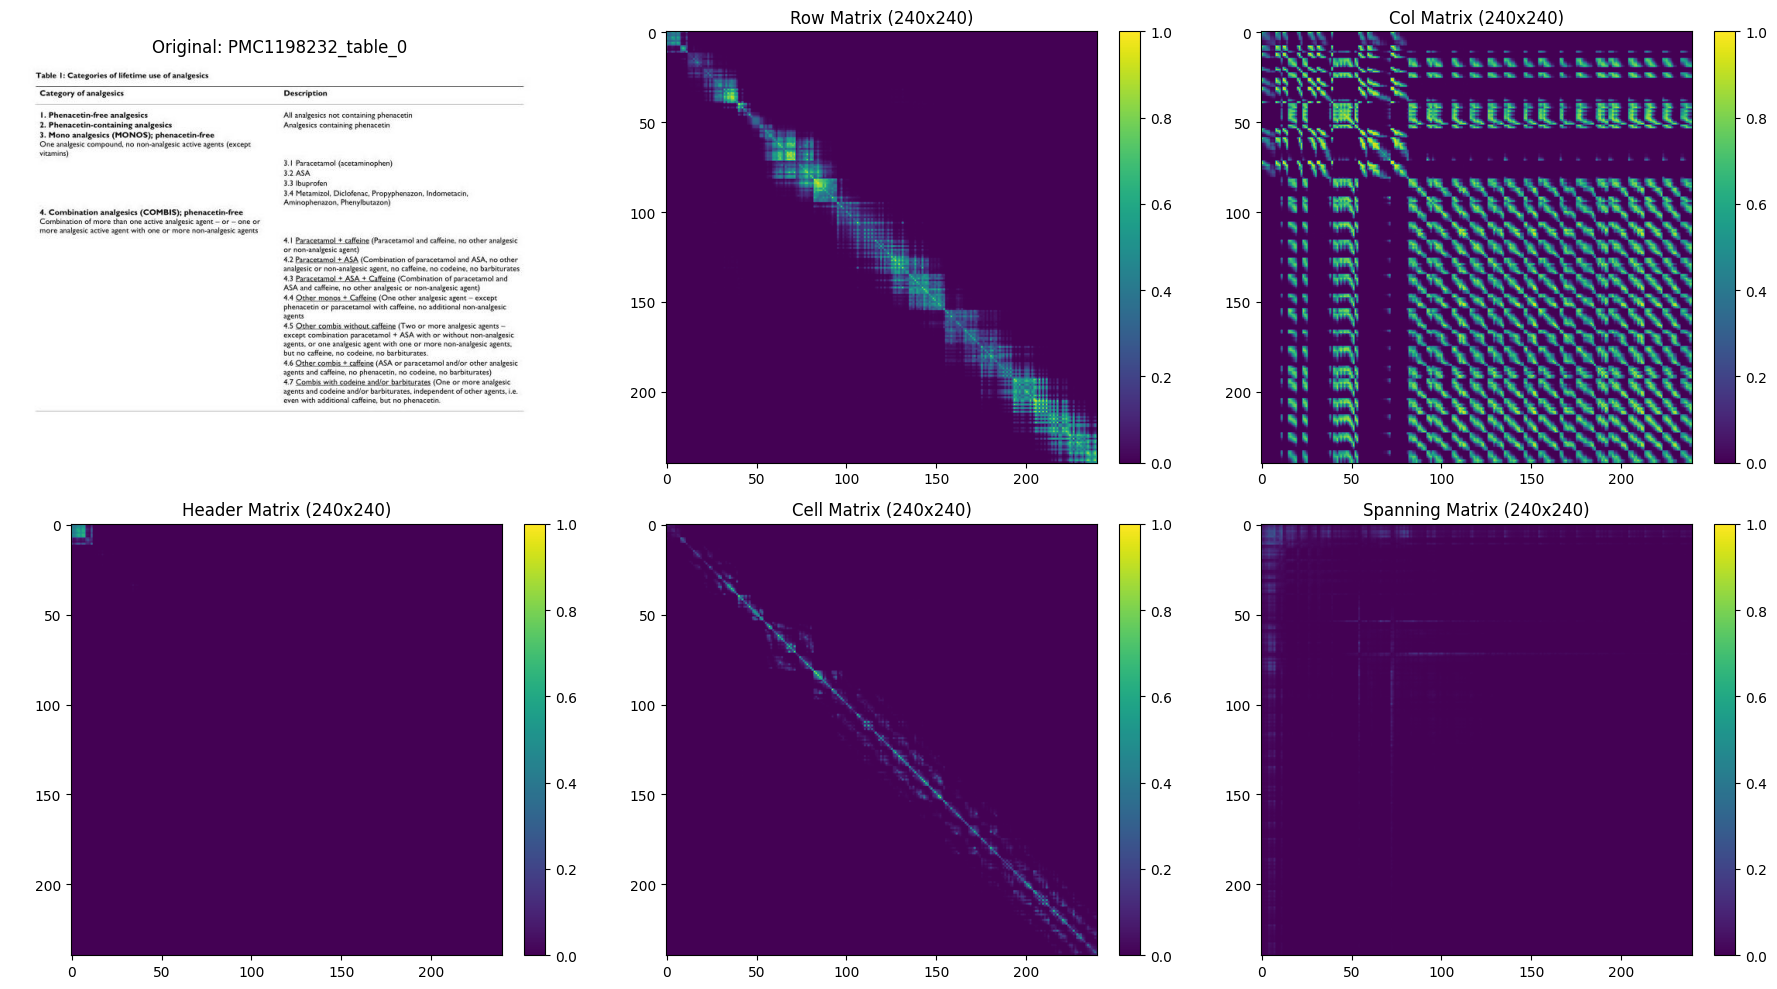

[4/10] Heatmaps for: PMC1199589_table_2


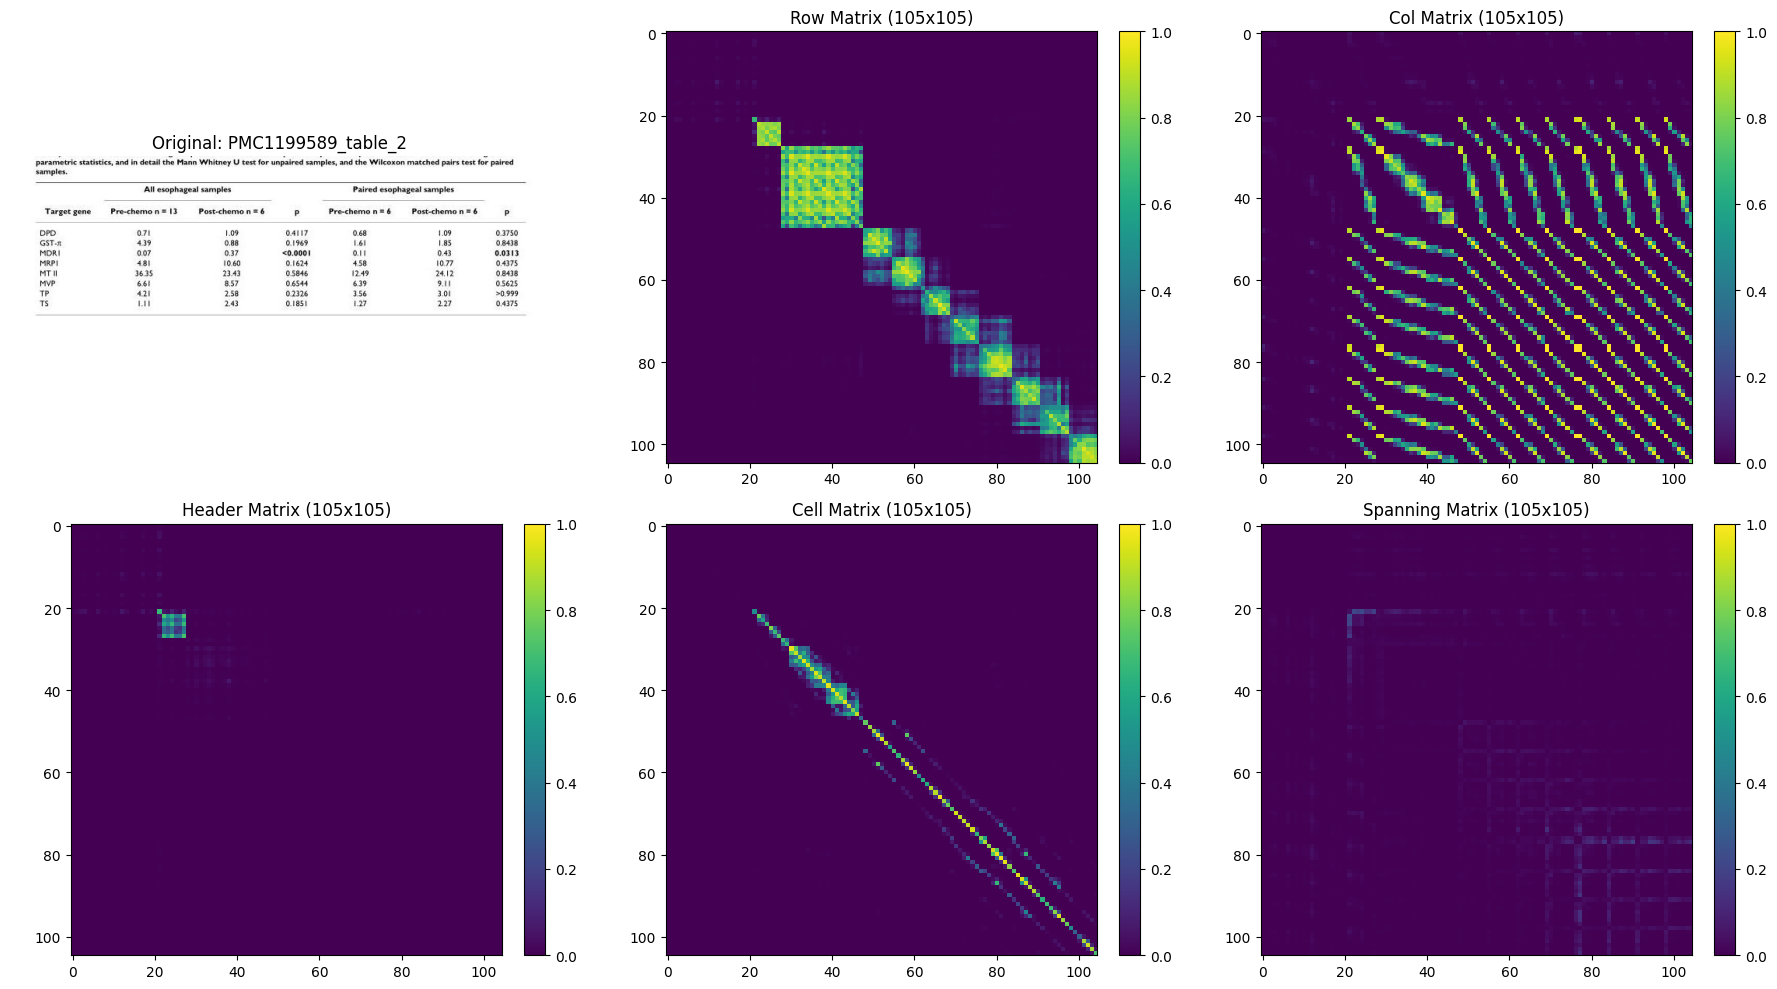

[5/10] Heatmaps for: PMC1208939_table_0


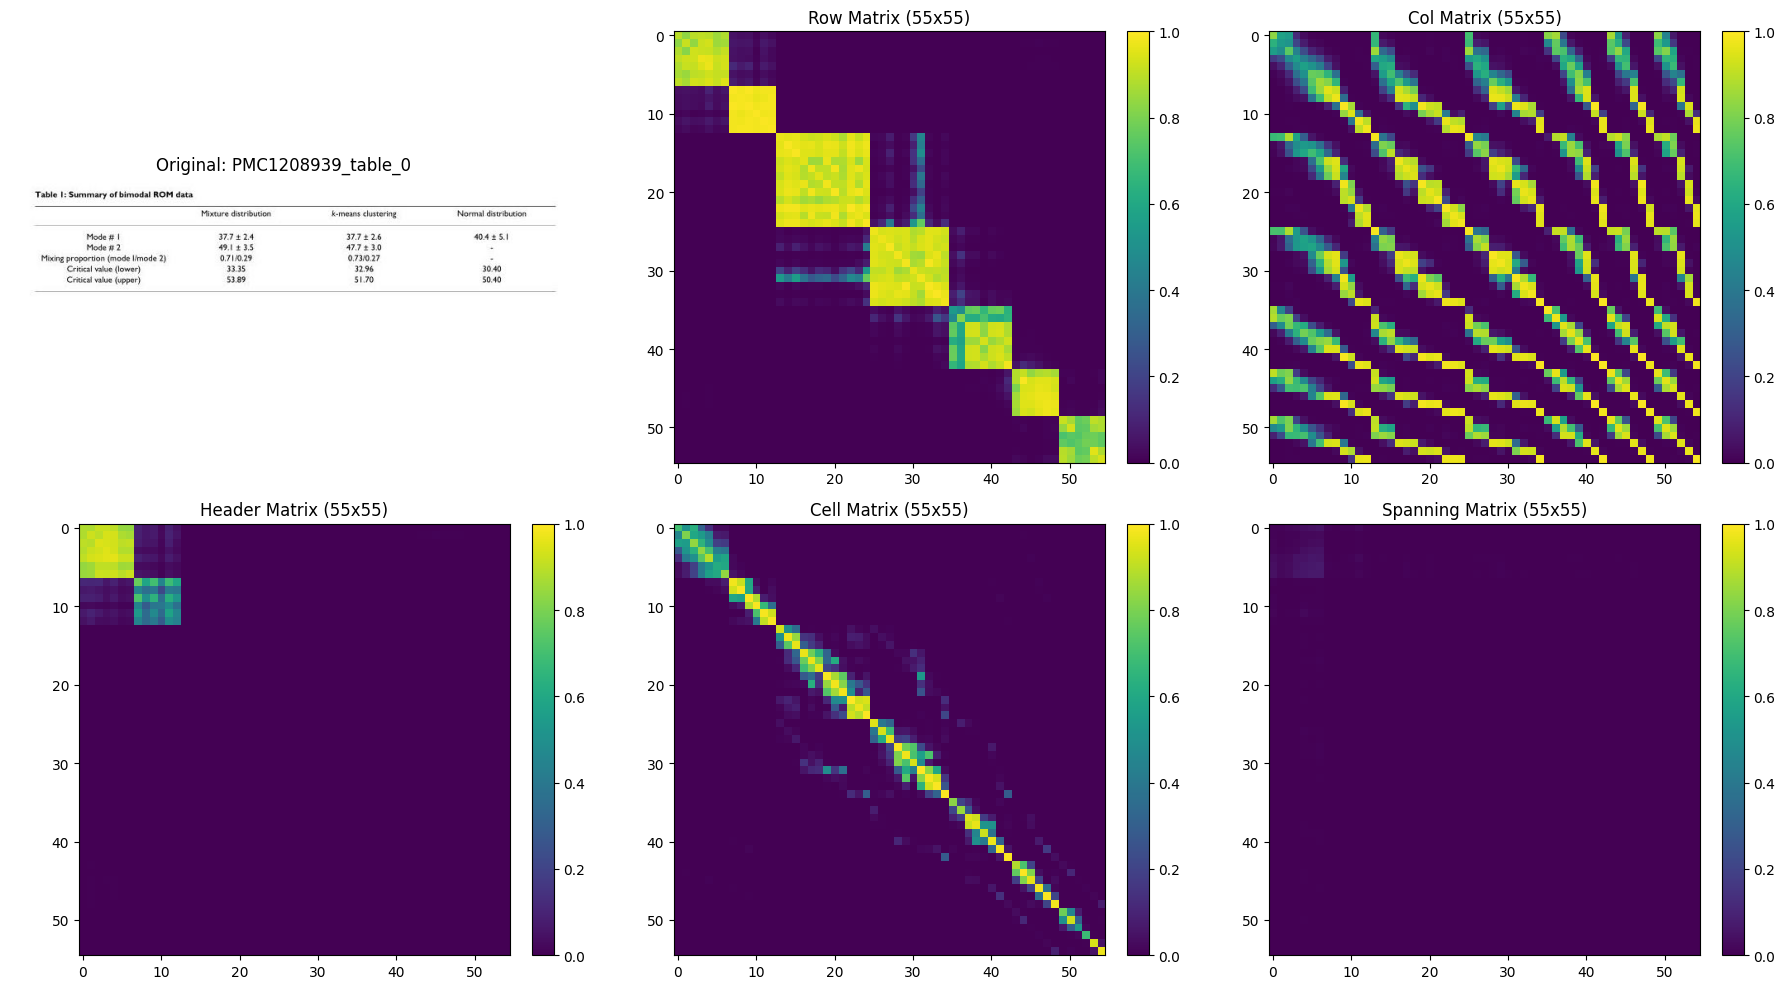

[6/10] Heatmaps for: PMC1261165_table_2


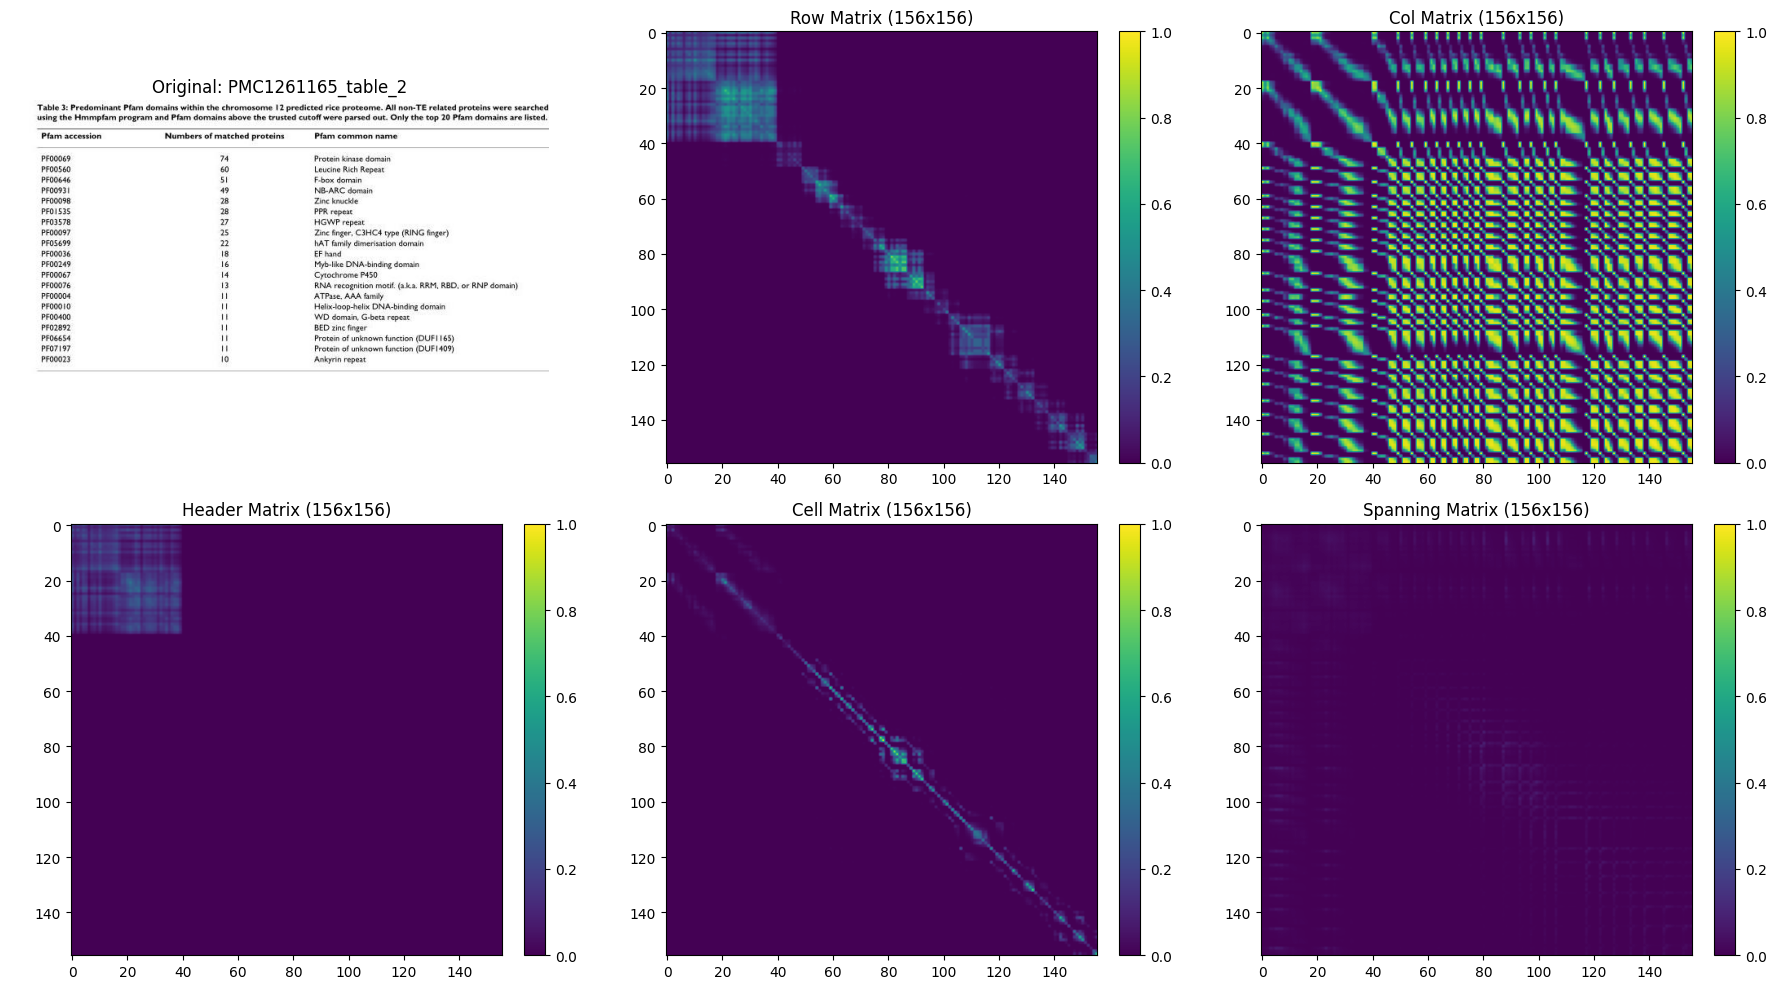

[7/10] Heatmaps for: PMC1262703_table_0


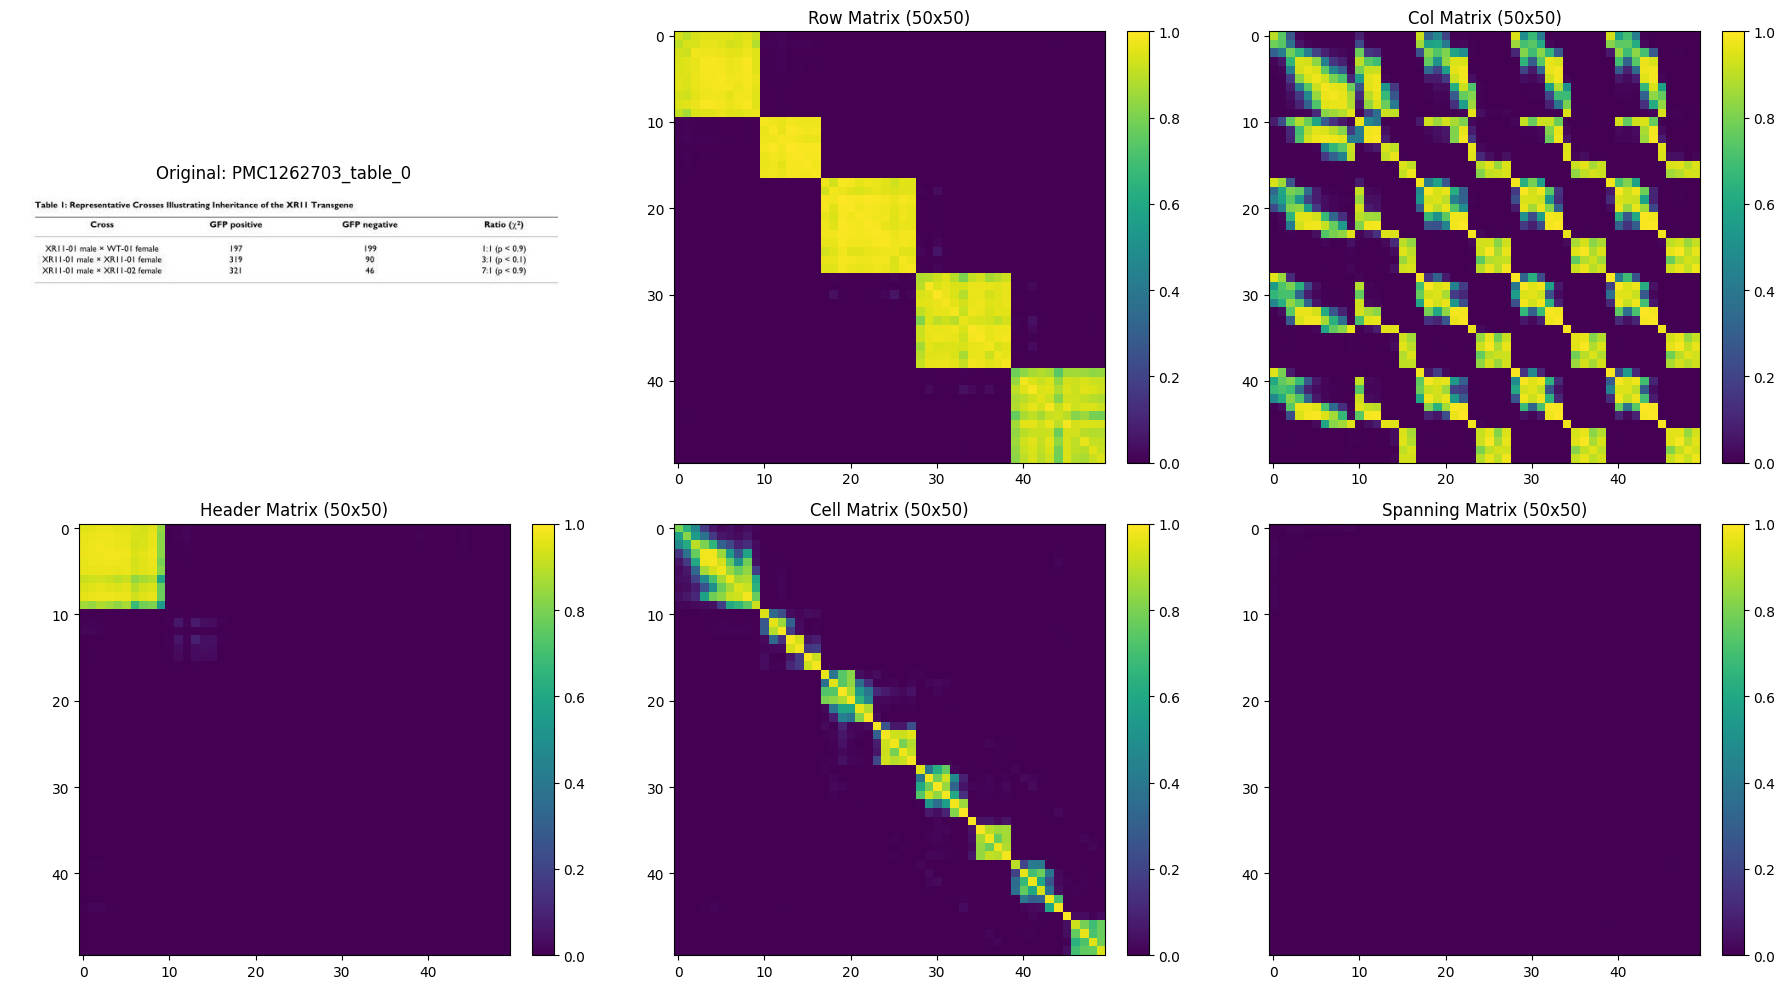

[8/10] Heatmaps for: PMC1322220_table_0


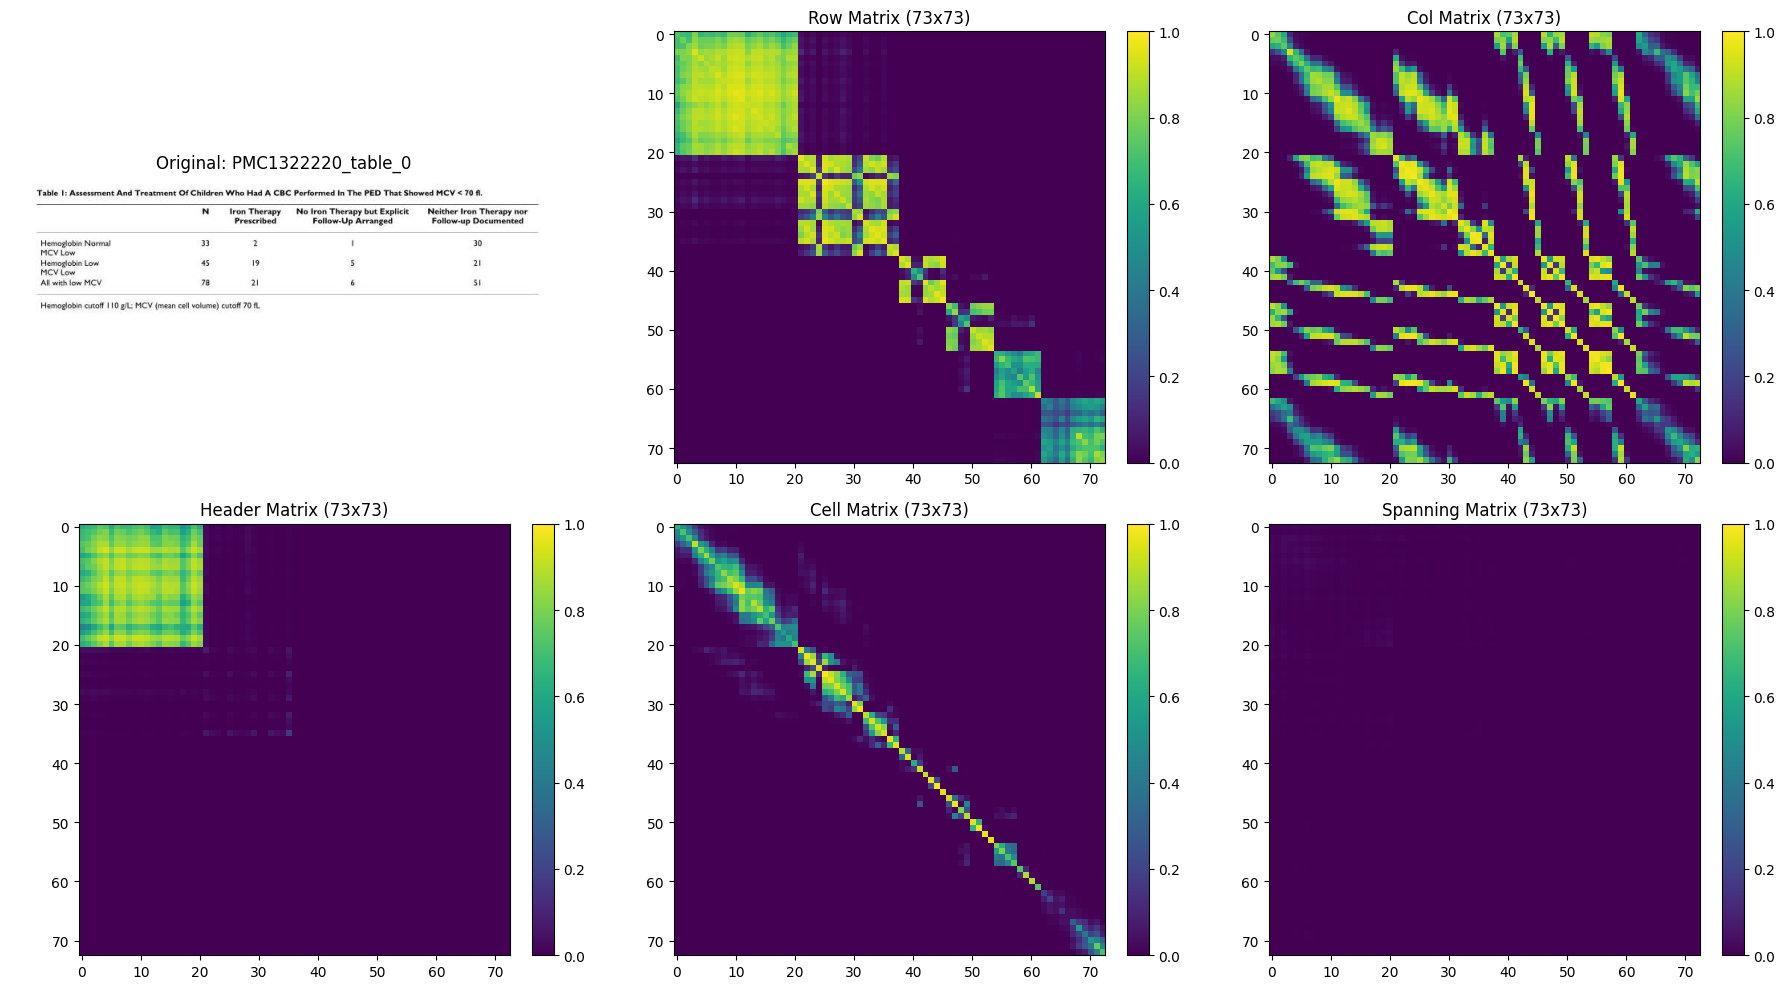

[9/10] Heatmaps for: PMC1397852_table_1


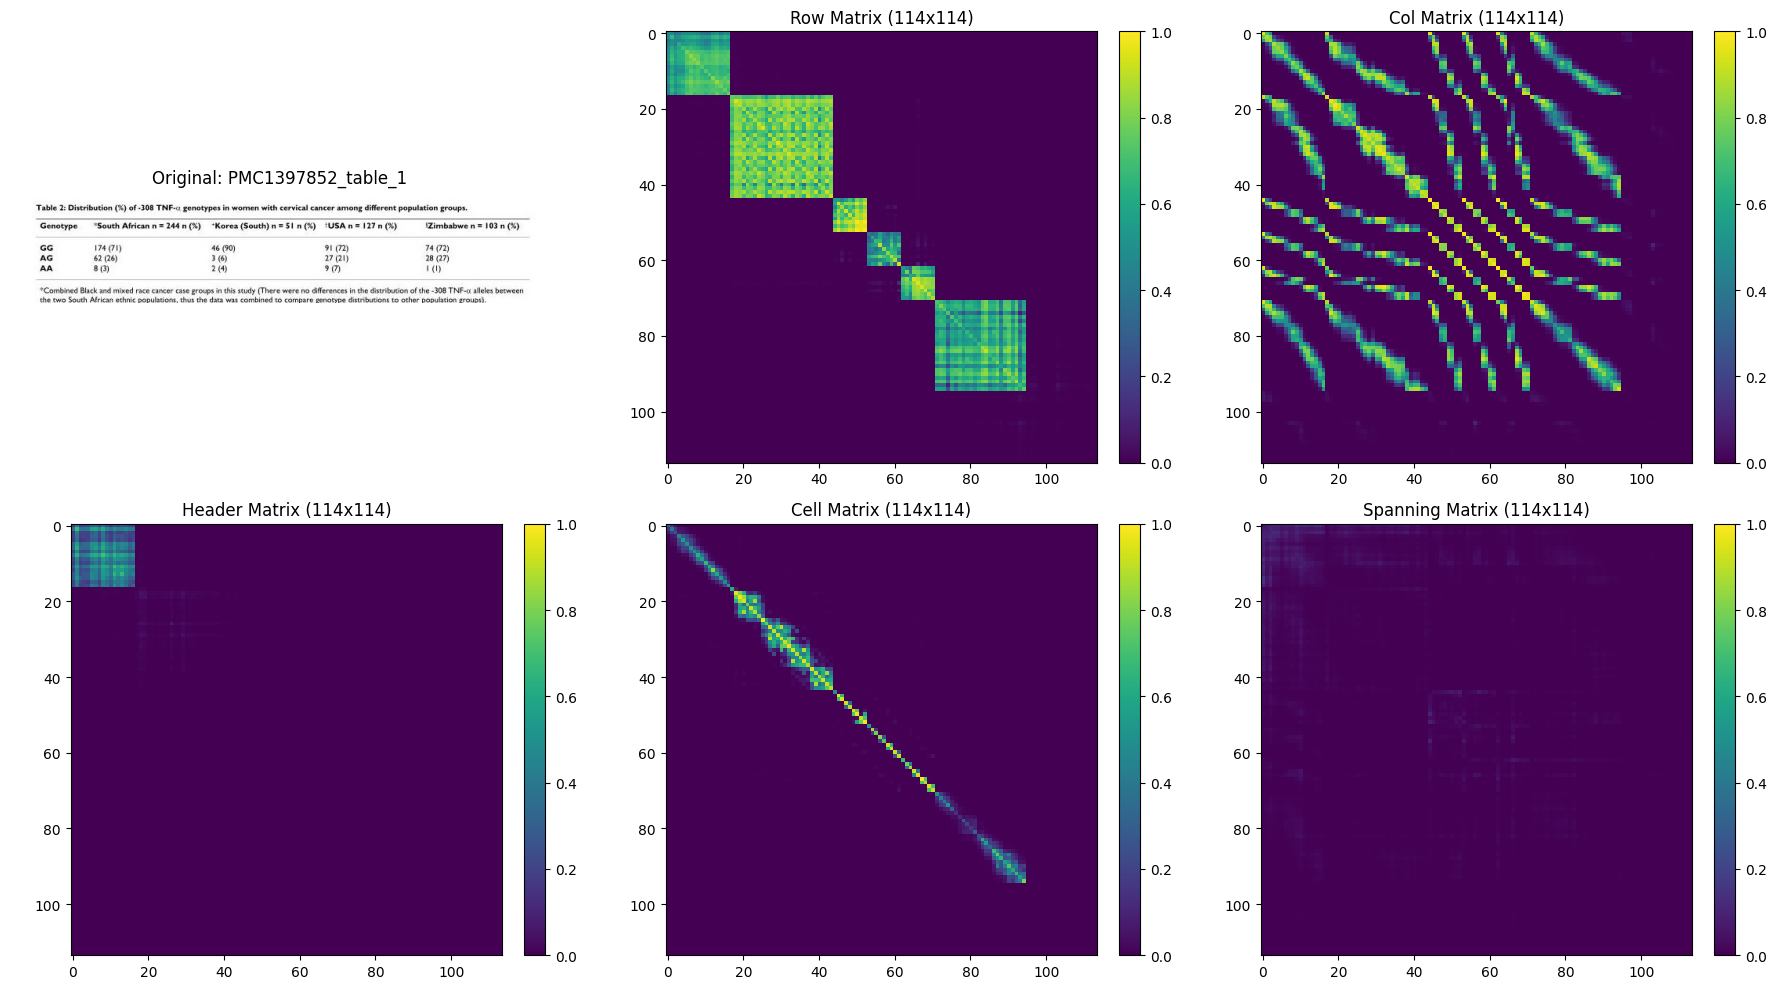

[10/10] Heatmaps for: PMC1431515_table_0


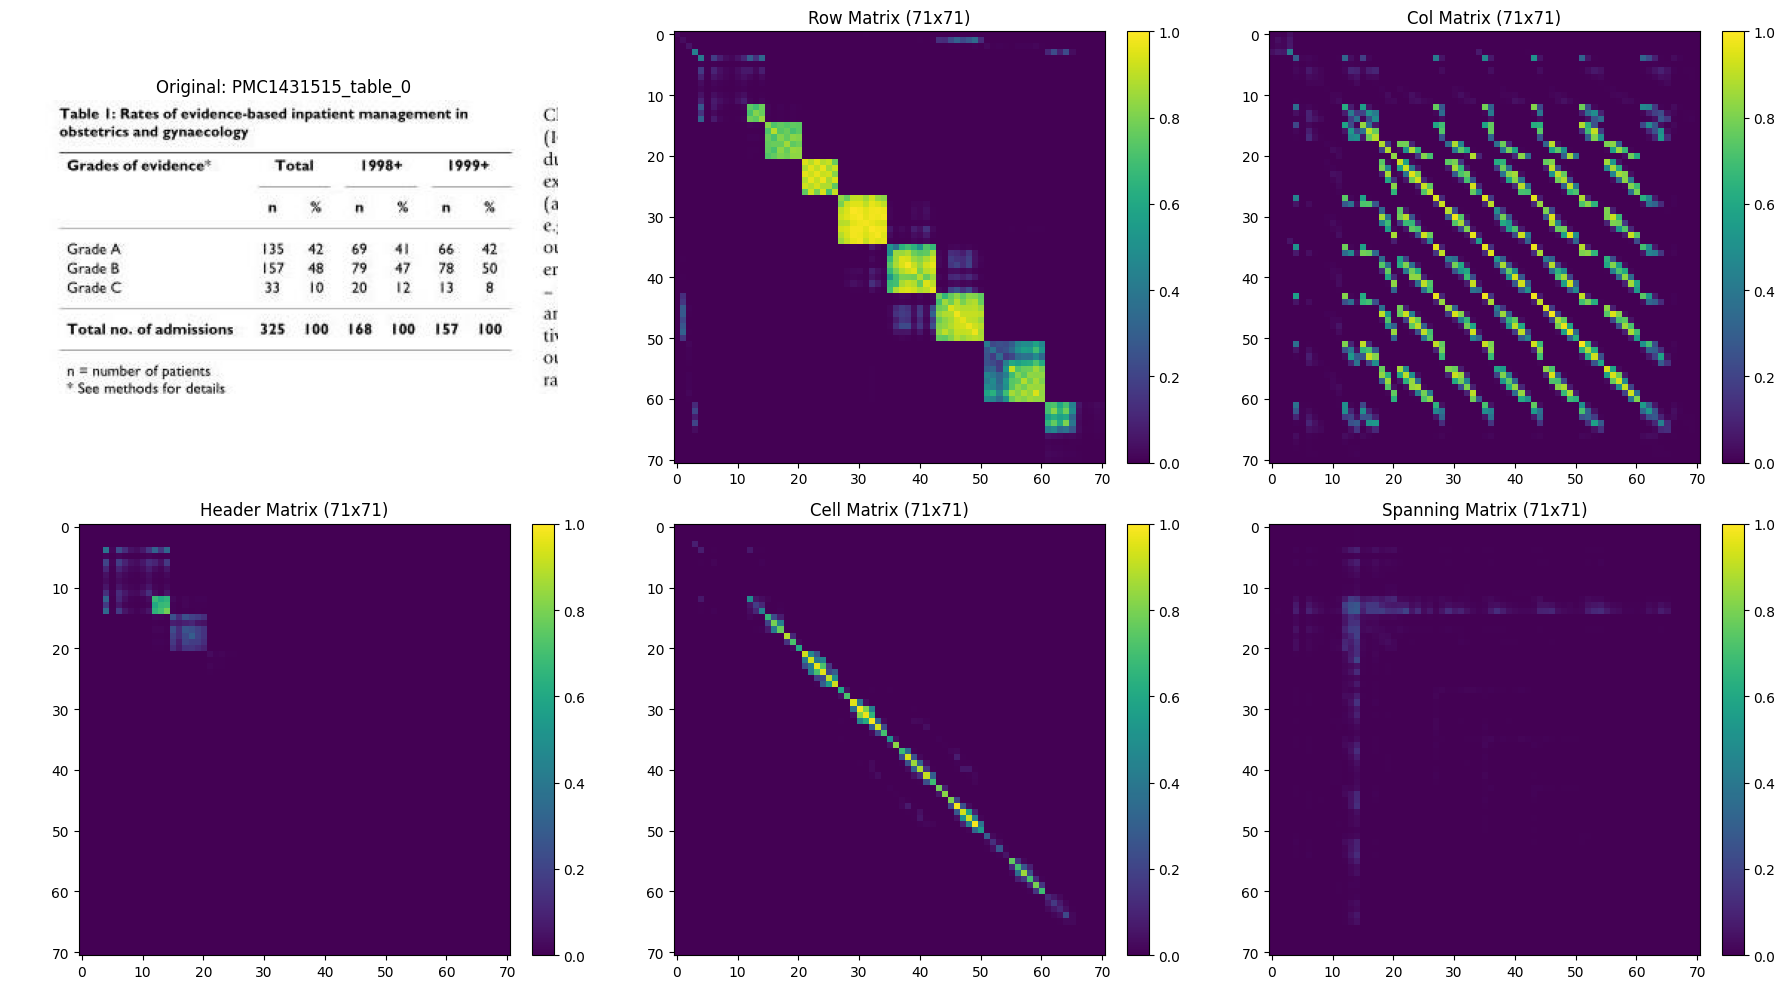

In [5]:
# 3. Run Inference & Visualize Matrices (Heatmaps)
json_files = sorted(glob.glob(os.path.join(VAL_JSON_DIR, "*.json")))[:MAX_SAMPLES]
print(f"Found {len(json_files)} samples to visualize.\n")

for idx, json_path in enumerate(json_files):
    base_name = os.path.basename(json_path)
    
    simple_name = base_name.replace("_words.json", "").replace(".json", "")
    img_path = os.path.join(VAL_IMG_DIR, simple_name + ".jpg")
    
    if not os.path.exists(img_path):
        if os.path.exists(os.path.join(VAL_IMG_DIR, simple_name + ".png")):
             img_path = os.path.join(VAL_IMG_DIR, simple_name + ".png")
        else:
             continue
             
    img = cv2.imread(img_path)
    if img is None: continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    
    # Preprocess
    input_ids, bbox_norm, mask, num_real = preprocess_input(json_path, vocab, img_size=(w, h))
    
    # Move to Device
    input_ids = input_ids.to(DEVICE)
    bbox_norm = bbox_norm.to(DEVICE)
    mask = mask.to(DEVICE)
    
    # Inference
    with torch.no_grad():
        outputs = model(input_ids, bbox_norm, mask=mask)
        
    # Post-process outputs to numpy
    pred_matrices = {}
    for k, v in outputs.items():
        mat = v[0].cpu().numpy()
        pred_matrices[k] = mat

    # Visualize Heatmaps
    print(f"[{idx+1}/{len(json_files)}] Heatmaps for: {simple_name}")
    plot_prediction_matrices(img_rgb, pred_matrices, num_real, simple_name)
    print("="*80)


VISUALIZATION LIKE VISUALIZE.PY (Combined View)

[1/10] Structure Recovery: PMC1087493_table_2

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  40 nhóm (threshold=0.5)
  Spanning Cell       :  42 nhóm (threshold=0.5)
  Hàng (Row)          :   9 nhóm (threshold=0.7)
  Cột (Column)        :   4 nhóm (threshold=0.7)
  Header              :   2 nhóm (threshold=0.7)


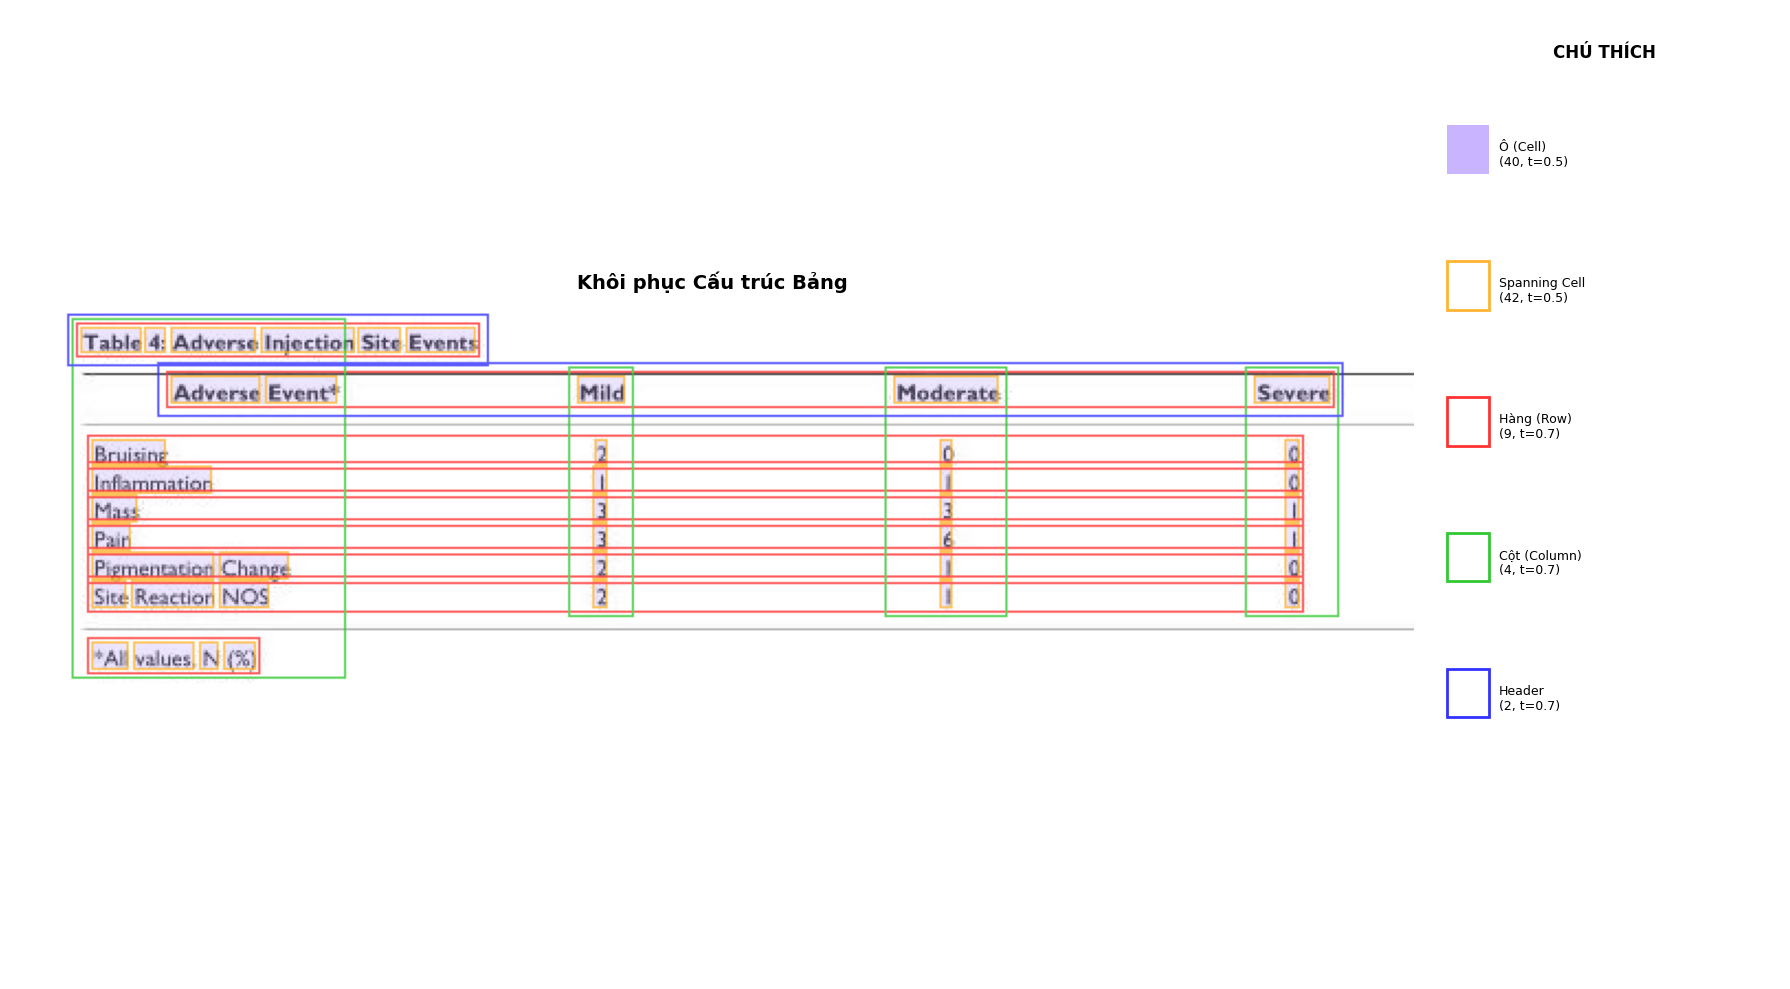


[2/10] Structure Recovery: PMC1180465_table_2

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  47 nhóm (threshold=0.5)
  Spanning Cell       : 108 nhóm (threshold=0.5)
  Hàng (Row)          :   9 nhóm (threshold=0.7)
  Cột (Column)        :   5 nhóm (threshold=0.7)
  Header              :   2 nhóm (threshold=0.7)


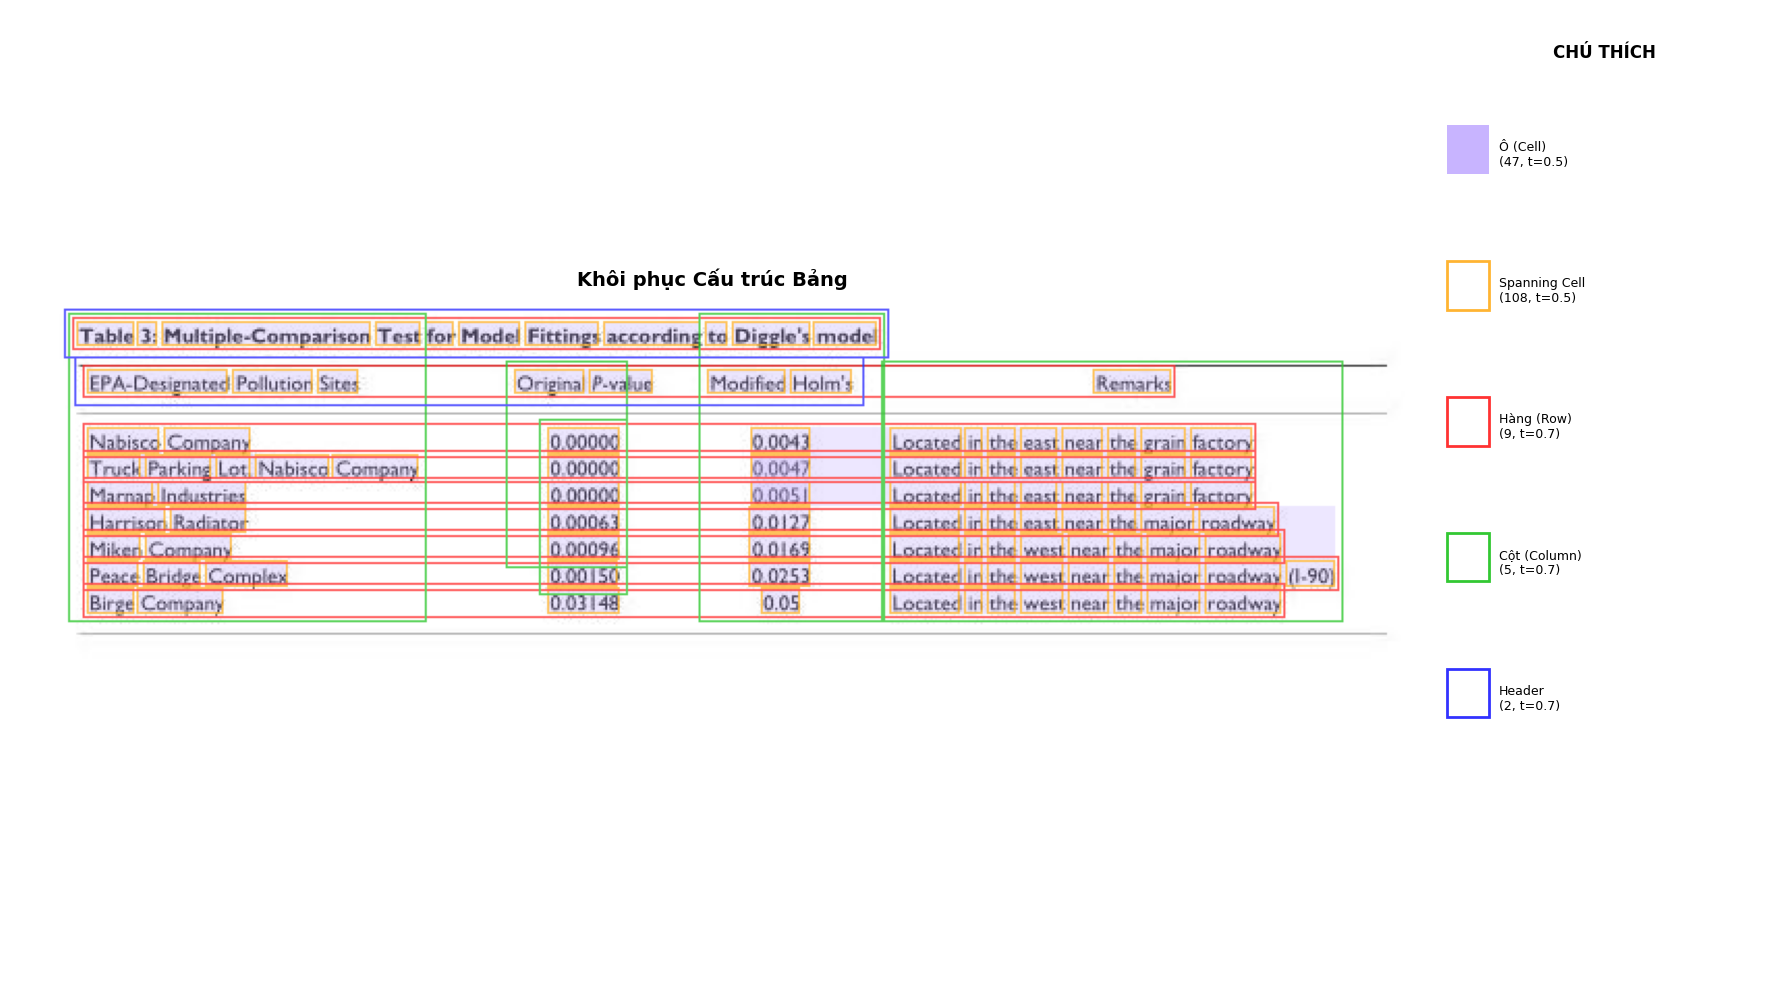


[3/10] Structure Recovery: PMC1198232_table_0

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            : 234 nhóm (threshold=0.5)
  Spanning Cell       : 240 nhóm (threshold=0.5)
  Hàng (Row)          :   6 nhóm (threshold=0.7)
  Cột (Column)        :   2 nhóm (threshold=0.7)
  Header              :   0 nhóm (threshold=0.7)


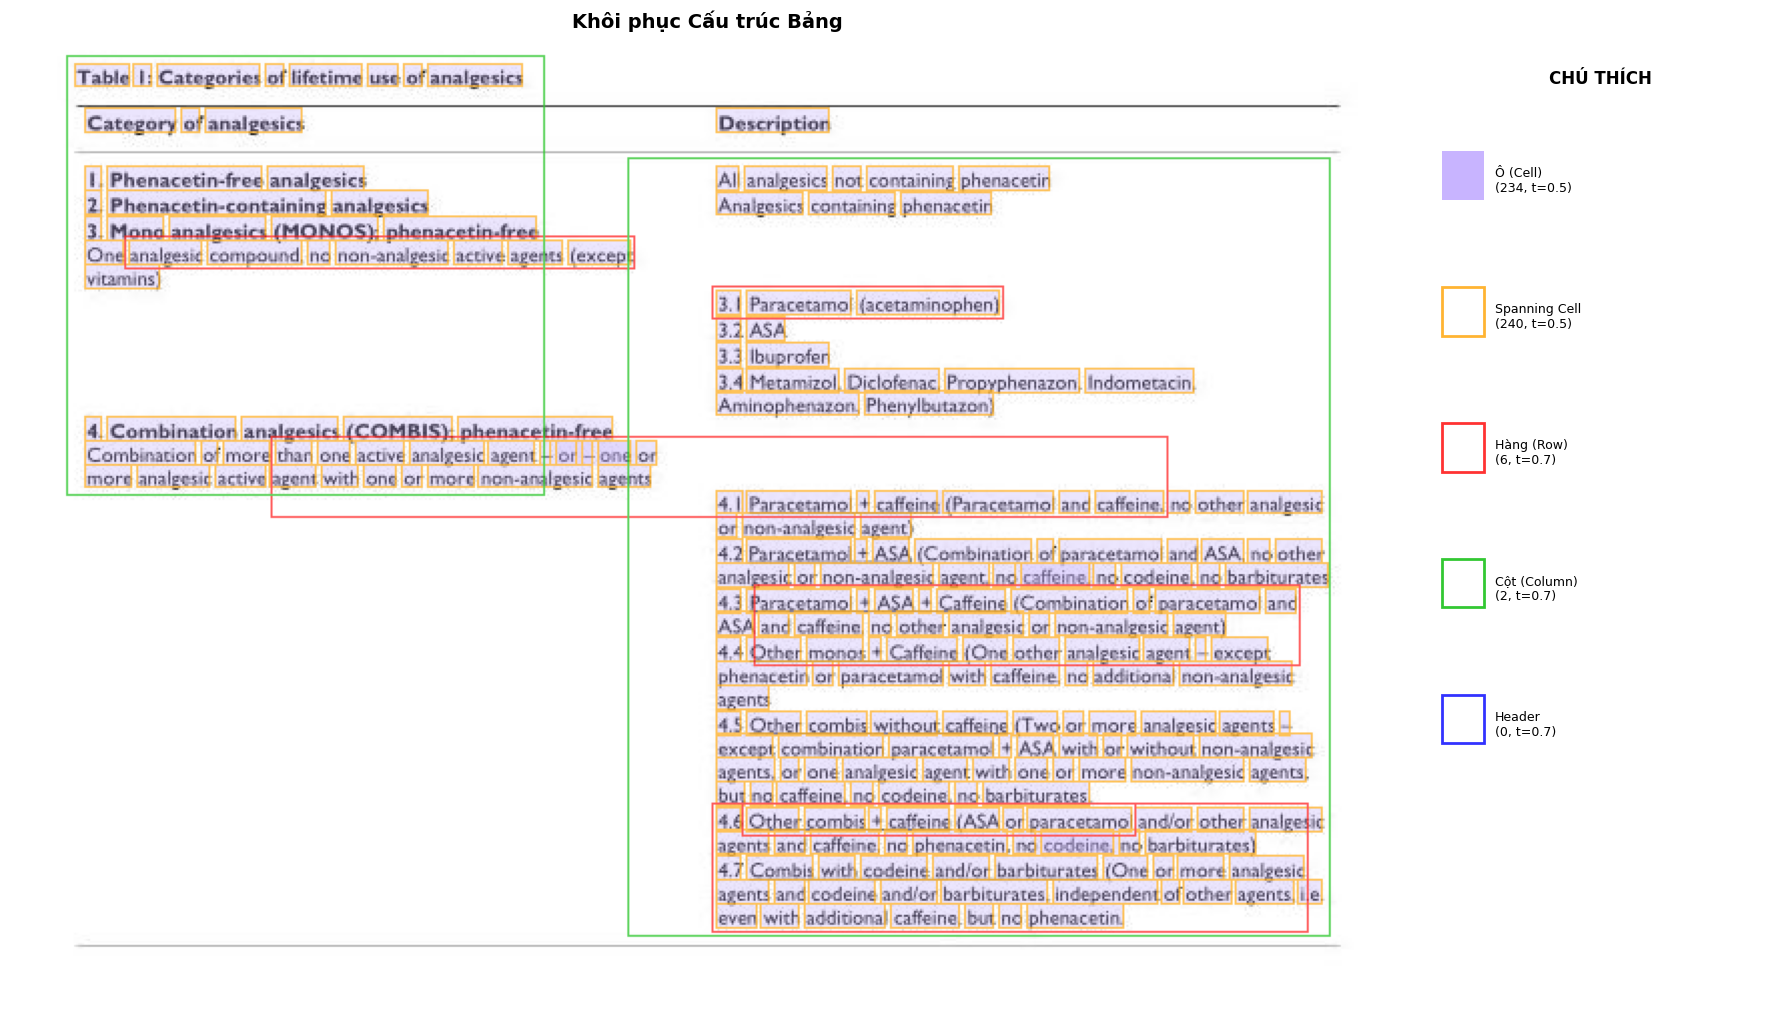


[4/10] Structure Recovery: PMC1199589_table_2

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  88 nhóm (threshold=0.5)
  Spanning Cell       : 105 nhóm (threshold=0.5)
  Hàng (Row)          :  10 nhóm (threshold=0.7)
  Cột (Column)        :   4 nhóm (threshold=0.7)
  Header              :   1 nhóm (threshold=0.7)


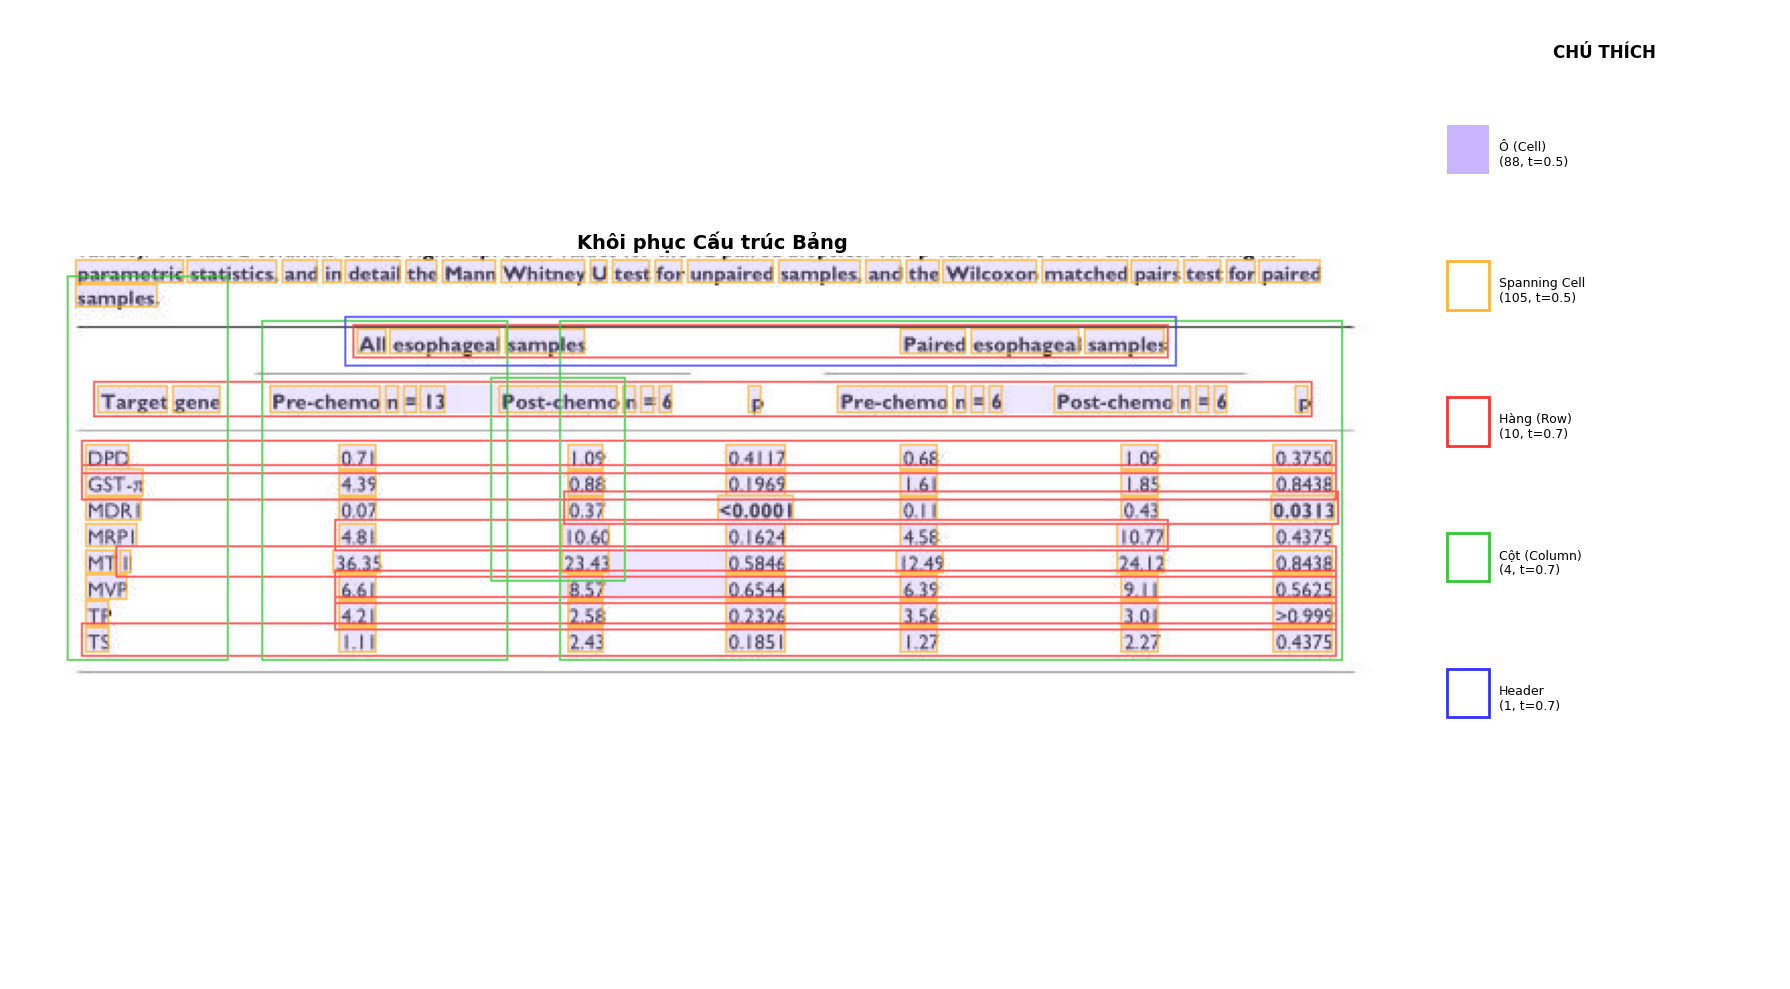


[5/10] Structure Recovery: PMC1208939_table_0

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  22 nhóm (threshold=0.5)
  Spanning Cell       :  55 nhóm (threshold=0.5)
  Hàng (Row)          :   6 nhóm (threshold=0.7)
  Cột (Column)        :   3 nhóm (threshold=0.7)
  Header              :   2 nhóm (threshold=0.7)


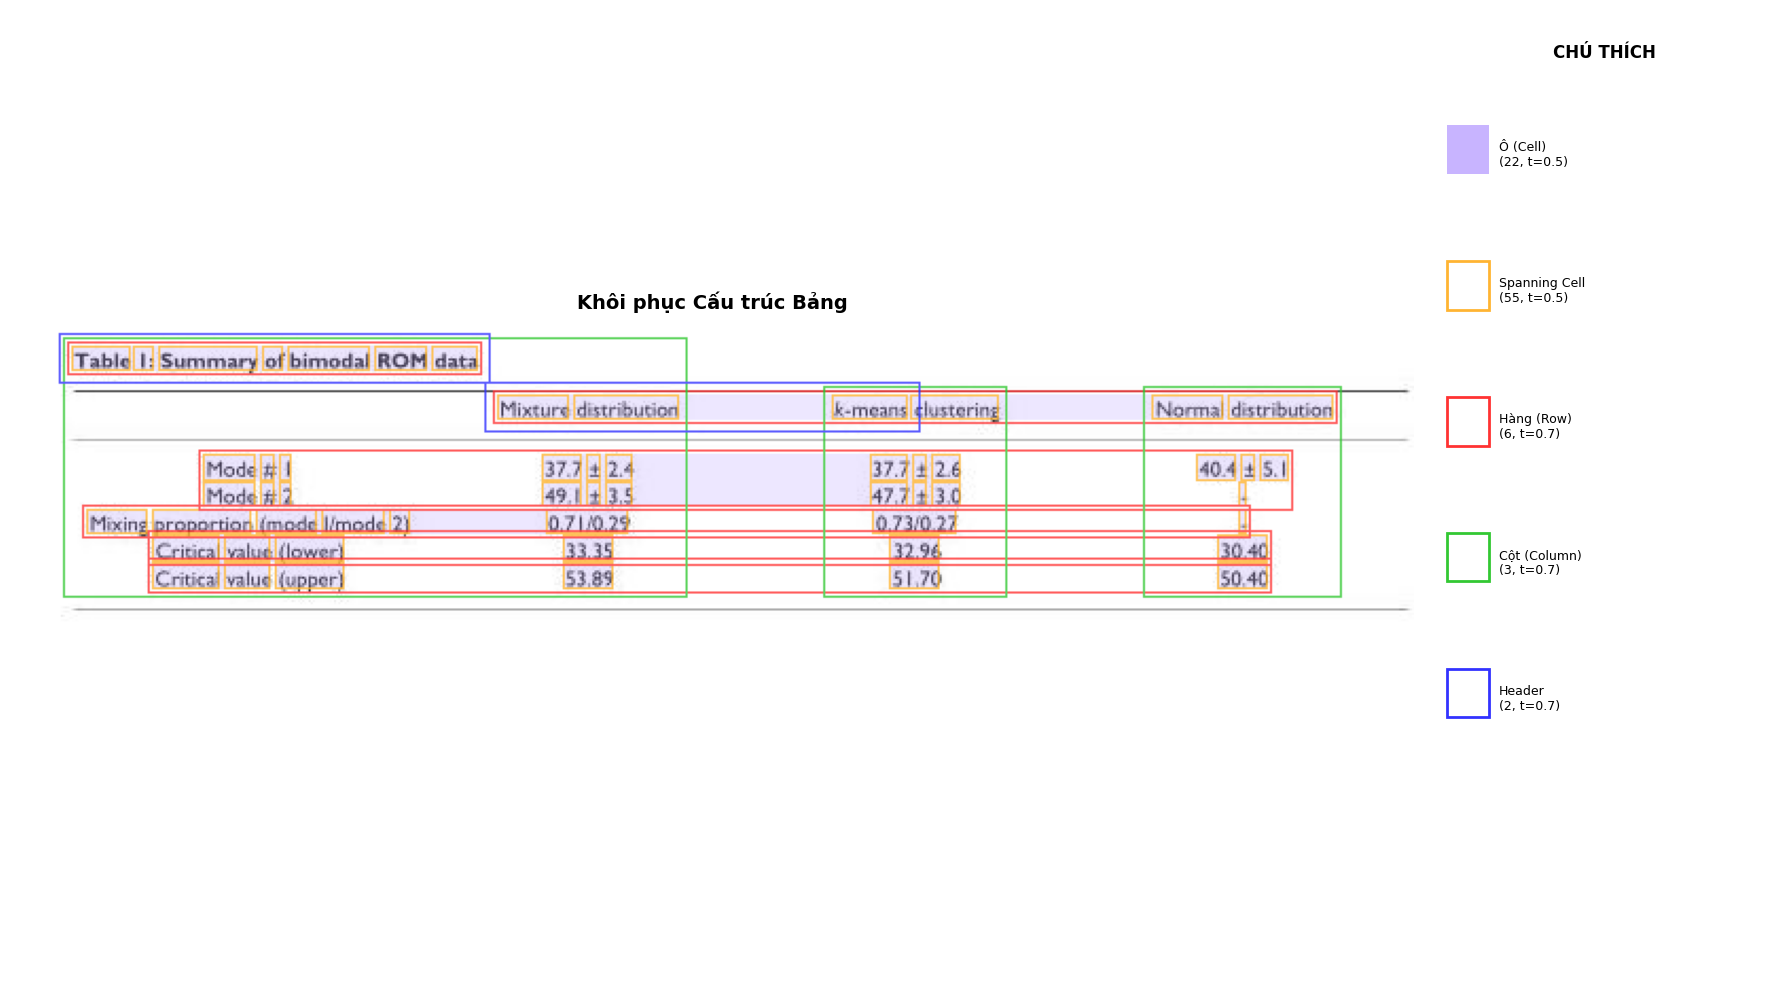


[6/10] Structure Recovery: PMC1261165_table_2

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            : 152 nhóm (threshold=0.5)
  Spanning Cell       : 156 nhóm (threshold=0.5)
  Hàng (Row)          :   1 nhóm (threshold=0.7)
  Cột (Column)        :   4 nhóm (threshold=0.7)
  Header              :   0 nhóm (threshold=0.7)


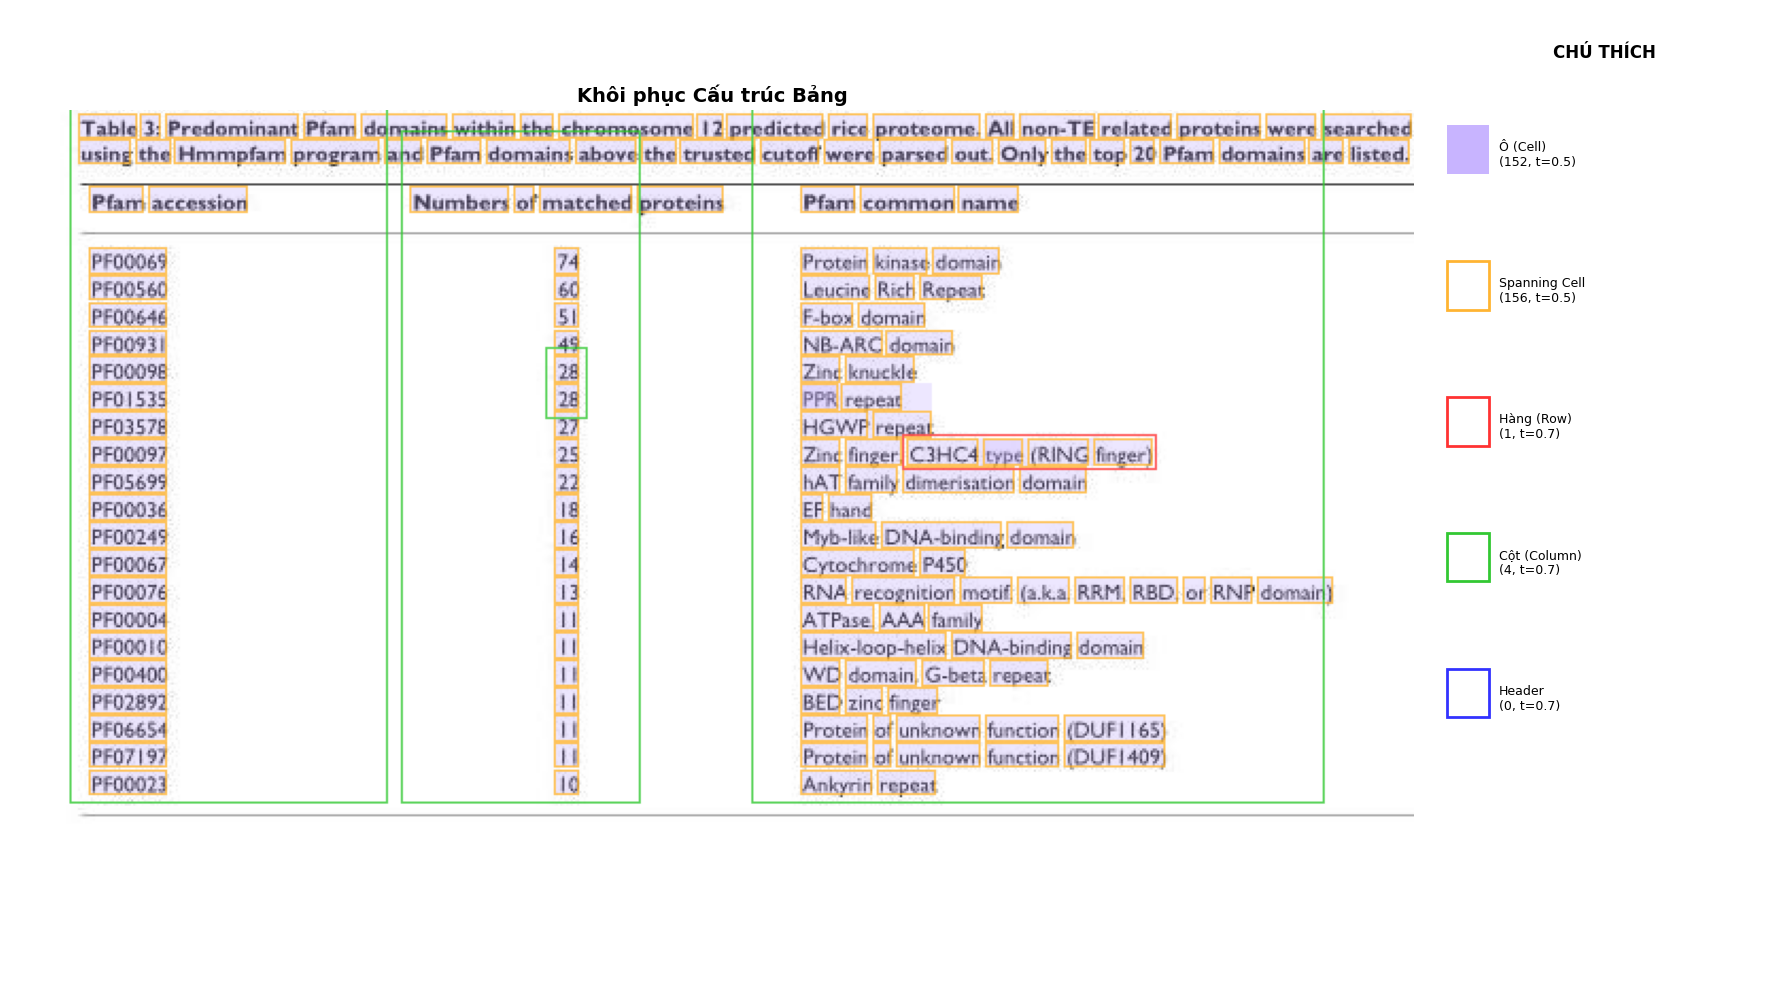


[7/10] Structure Recovery: PMC1262703_table_0

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  16 nhóm (threshold=0.5)
  Spanning Cell       :  50 nhóm (threshold=0.5)
  Hàng (Row)          :   5 nhóm (threshold=0.7)
  Cột (Column)        :   2 nhóm (threshold=0.7)
  Header              :   1 nhóm (threshold=0.7)


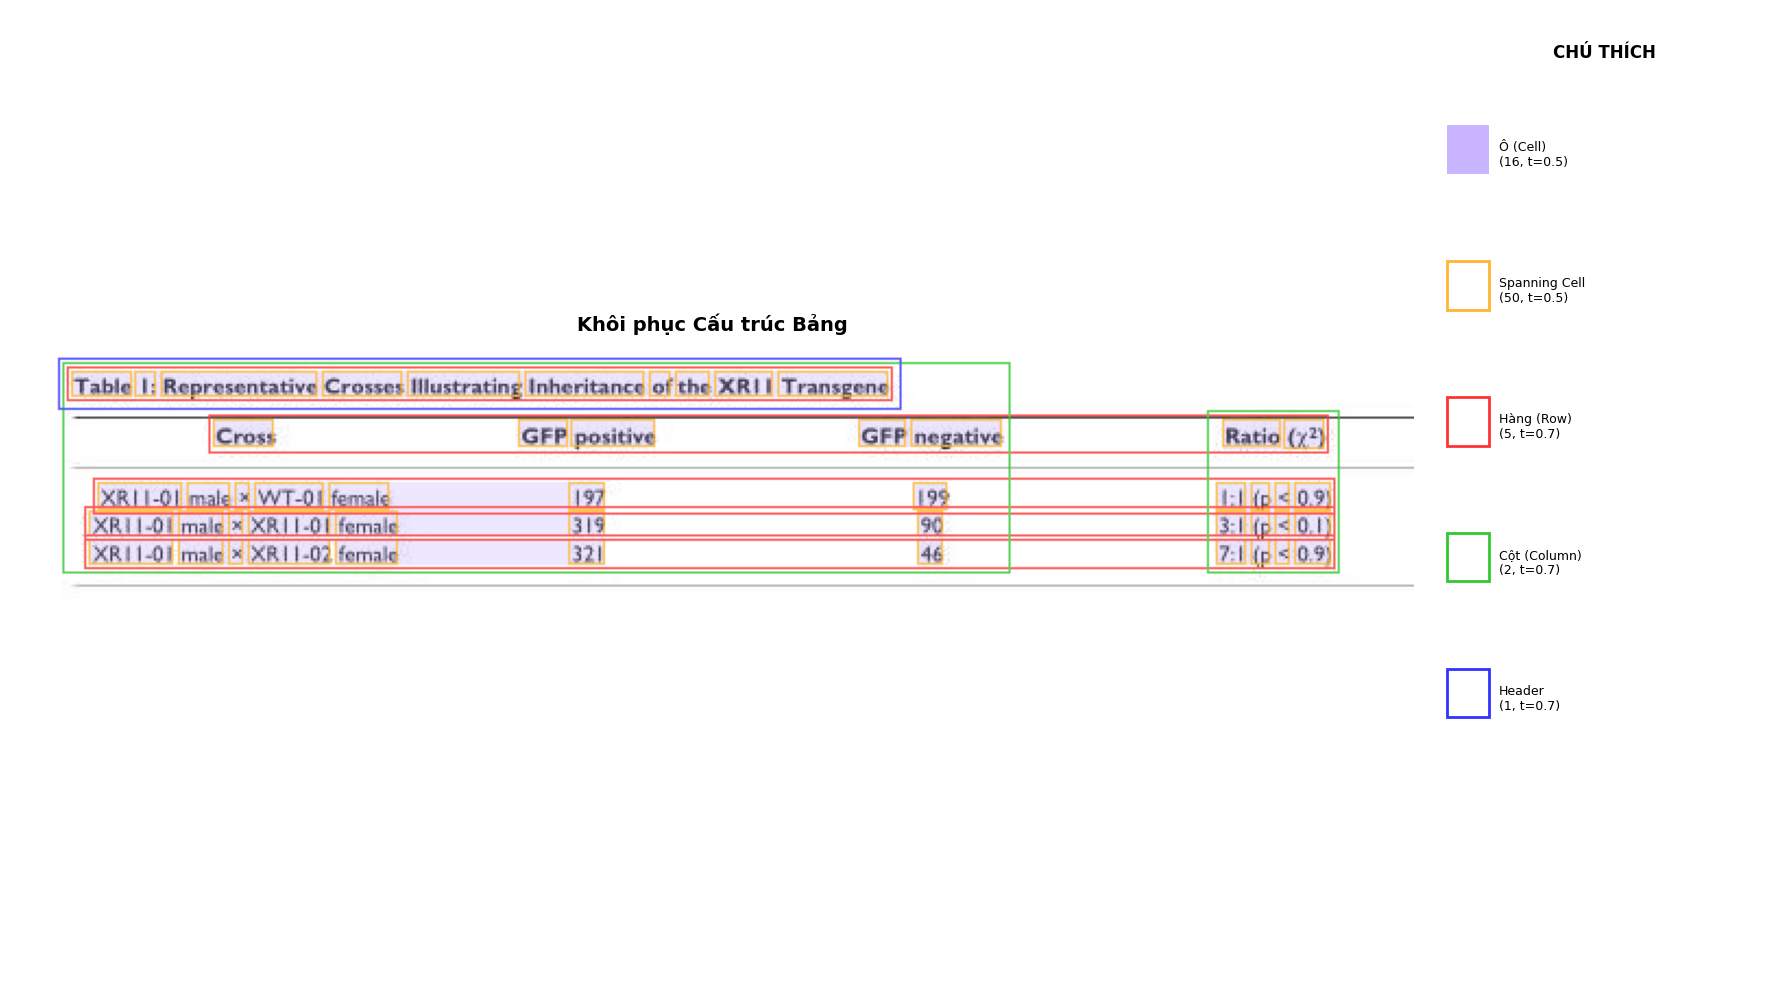


[8/10] Structure Recovery: PMC1322220_table_0

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  42 nhóm (threshold=0.5)
  Spanning Cell       :  73 nhóm (threshold=0.5)
  Hàng (Row)          :   7 nhóm (threshold=0.7)
  Cột (Column)        :   3 nhóm (threshold=0.7)
  Header              :   1 nhóm (threshold=0.7)


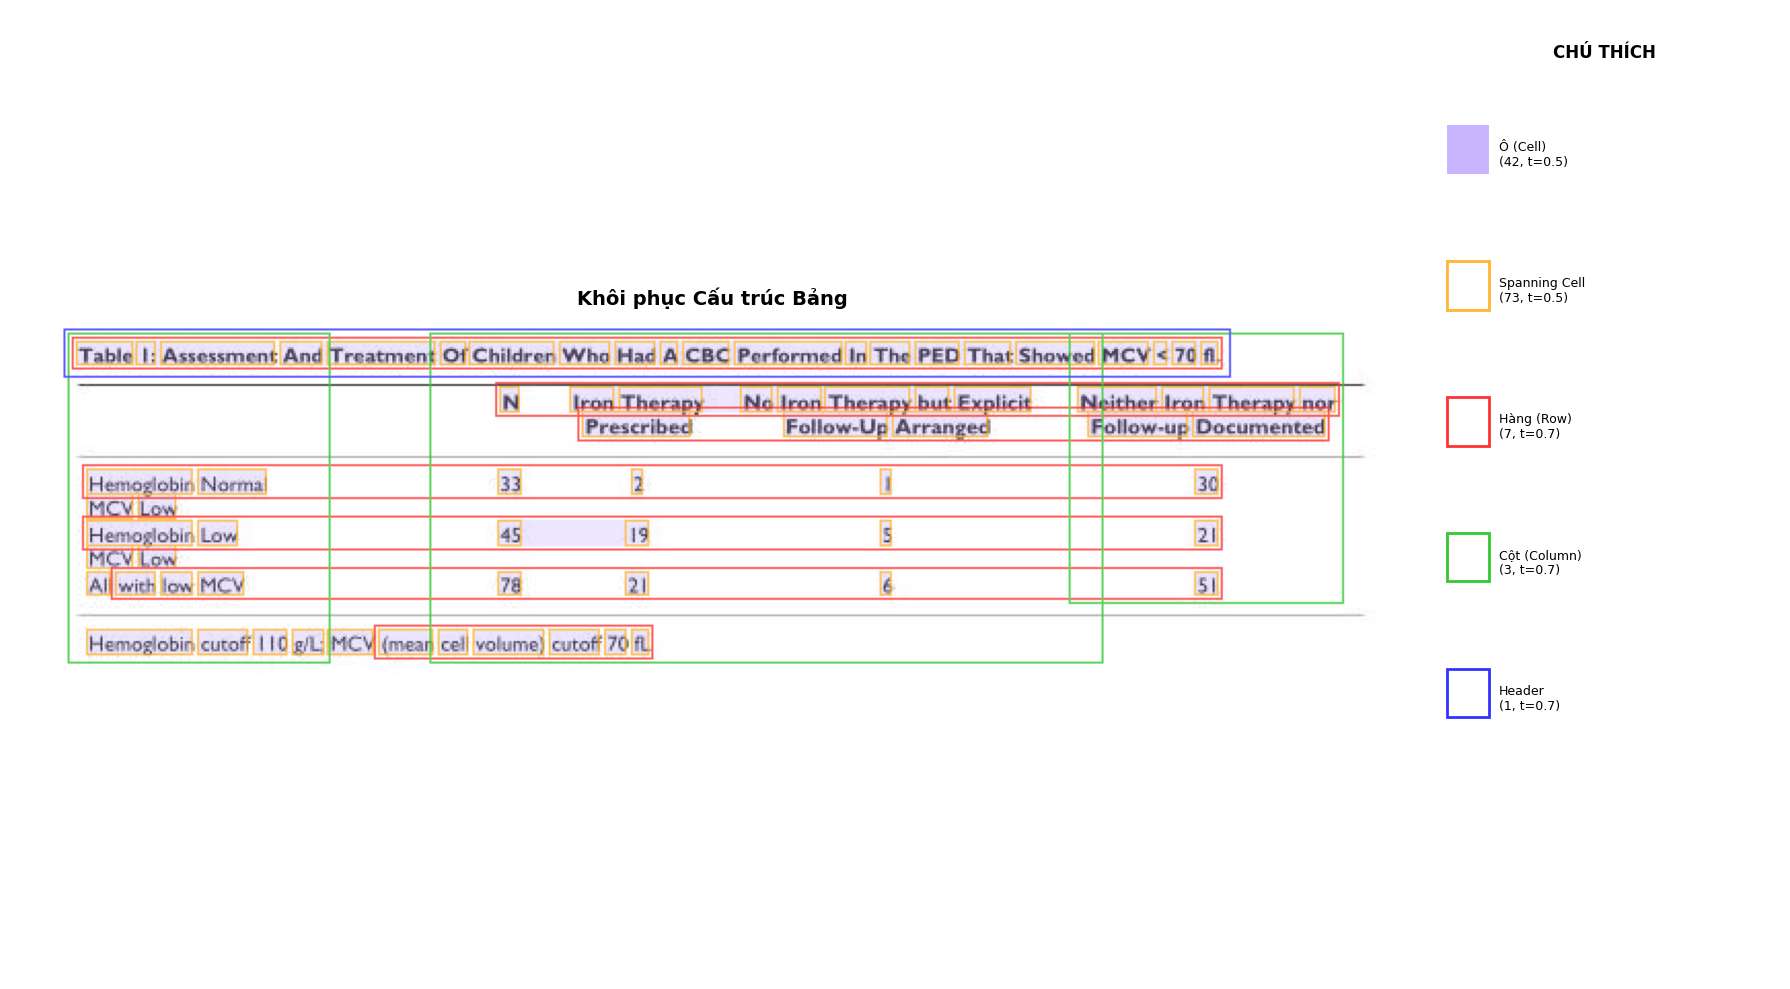


[9/10] Structure Recovery: PMC1397852_table_1

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  85 nhóm (threshold=0.5)
  Spanning Cell       : 114 nhóm (threshold=0.5)
  Hàng (Row)          :   6 nhóm (threshold=0.7)
  Cột (Column)        :   2 nhóm (threshold=0.7)
  Header              :   0 nhóm (threshold=0.7)


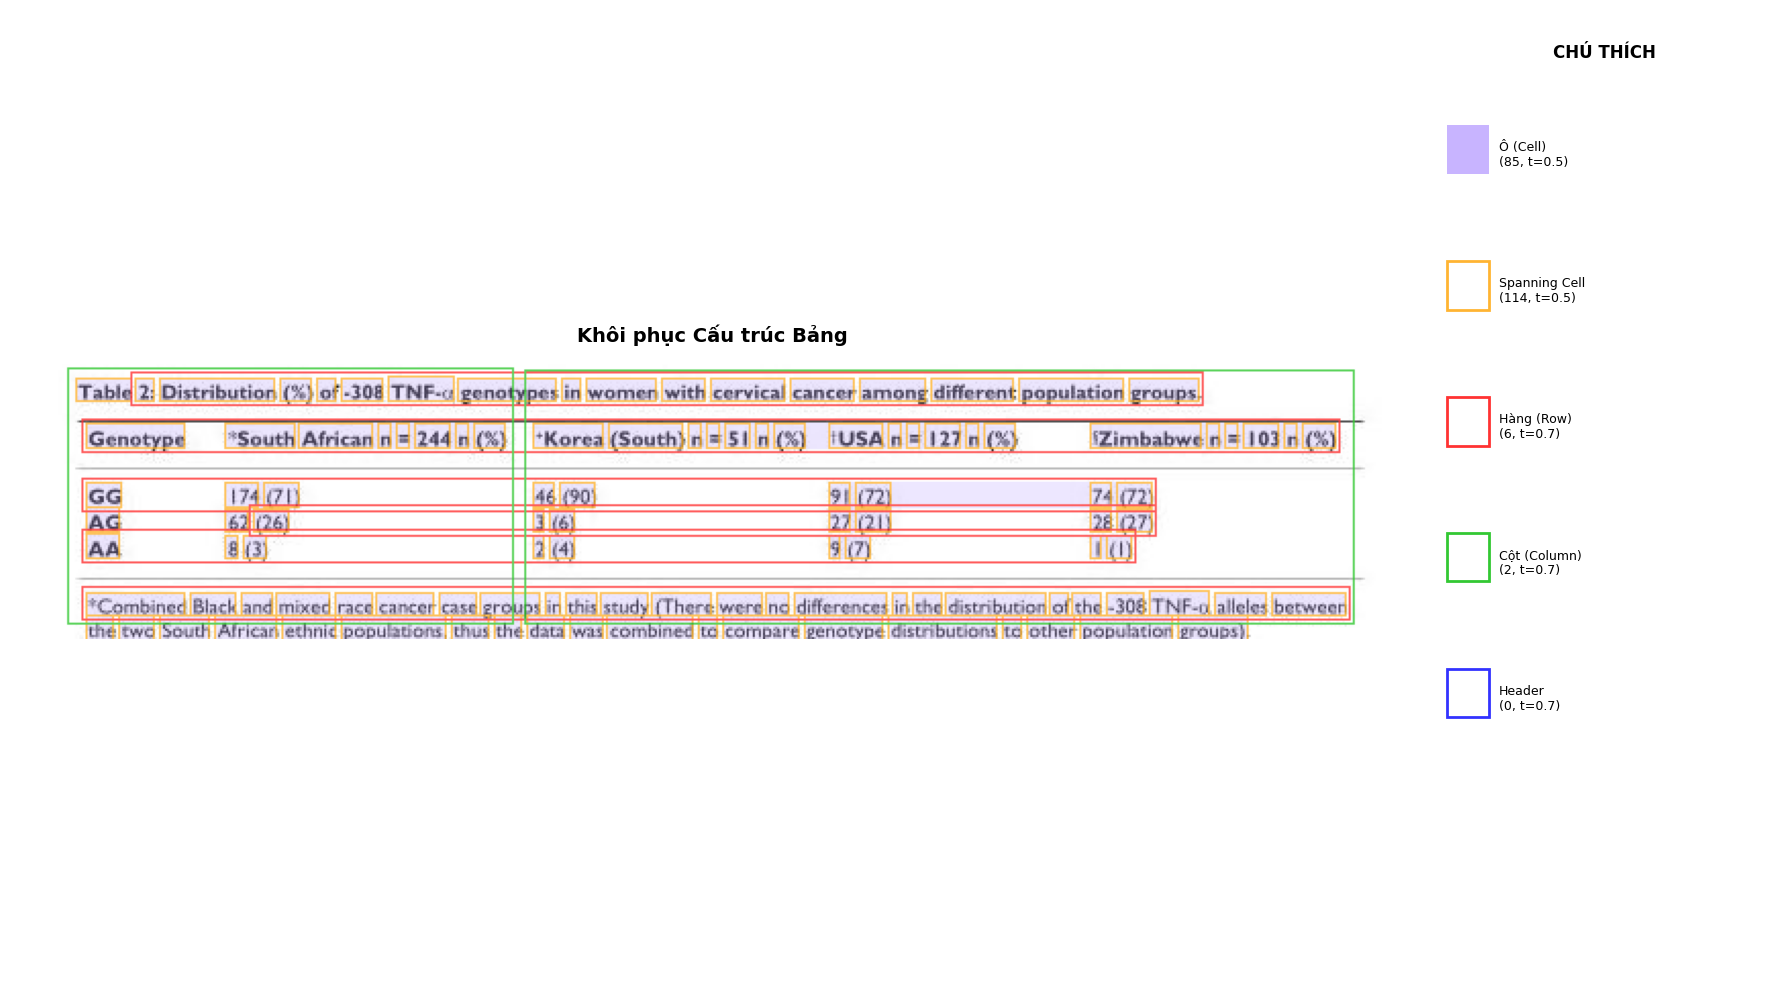


[10/10] Structure Recovery: PMC1431515_table_0

KHÔI PHỤC CẤU TRÚC BẢNG (Threshold tùy chỉnh)
  Ô (Cell)            :  66 nhóm (threshold=0.5)
  Spanning Cell       :  71 nhóm (threshold=0.5)
  Hàng (Row)          :   8 nhóm (threshold=0.7)
  Cột (Column)        :   2 nhóm (threshold=0.7)
  Header              :   0 nhóm (threshold=0.7)


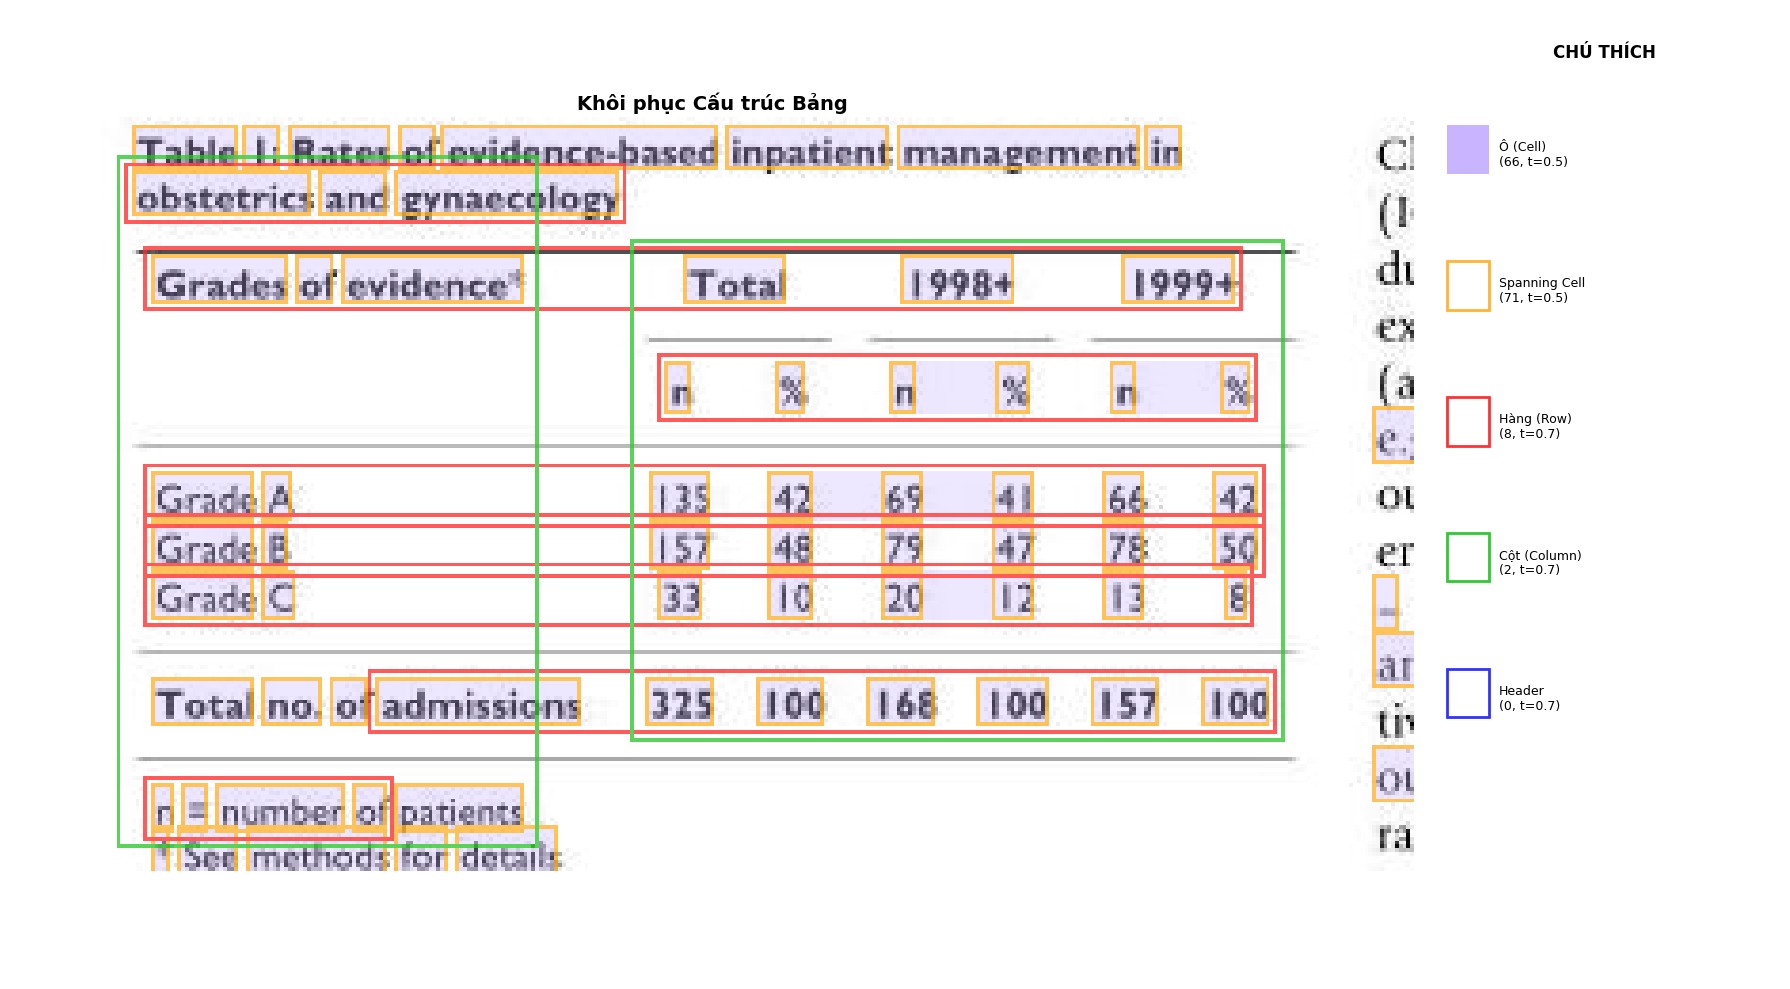

In [6]:
# 4. VISUALIZE COMBINED STRUCTURE (Giống visualize.py)
# Cell này sẽ vẽ các đường bao (border) cho Rows, Columns, Cells đè lên ảnh gốc

print("\n" + "="*40)
print("VISUALIZATION LIKE VISUALIZE.PY (Combined View)")
print("="*40 + "\n")

for idx, json_path in enumerate(json_files):
    base_name = os.path.basename(json_path)
    simple_name = base_name.replace("_words.json", "").replace(".json", "")
    img_path = os.path.join(VAL_IMG_DIR, simple_name + ".jpg")
    
    if not os.path.exists(img_path):
        if os.path.exists(os.path.join(VAL_IMG_DIR, simple_name + ".png")):
             img_path = os.path.join(VAL_IMG_DIR, simple_name + ".png")
        else:
             continue

    # 1. Load Raw Word Boxes (Bắt buộc để vẽ lên ảnh)
    with open(json_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    
    # Preprocess & Inference lại (để lấy outputs)
    img = cv2.imread(img_path)
    if img is None: continue
    # visualize_table_combined nhận ảnh RGB hoặc BGR
    # Nhưng nó có đoạn cvtColor bên trong nếu là path.
    # Nếu truyền ảnh numpy thì ta nên đưa ảnh BGR (mặc định cv2) để nó tự xử hoặc RGB nếu nó expect RGB.
    # Check code visualize: nếu truyền numpy, nó dùng luôn. 
    # Ta sẽ truyền ảnh RGB vào cho chuẩn.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    input_ids, bbox_norm, mask, num_real = preprocess_input(json_path, vocab, img_size=(w, h))
    input_ids = input_ids.to(DEVICE)
    bbox_norm = bbox_norm.to(DEVICE)
    mask = mask.to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids, bbox_norm, mask=mask)

    # Setup input cho hàm visualized
    # Raw Boxes cắt đúng số lượng từ thật
    raw_word_boxes = [item['bbox'] for item in raw_data[:512]] 
    raw_word_boxes = raw_word_boxes[:num_real]

    # Clean matrices (cắt đúng kích thước)
    clean_matrices = {}
    for k, v in outputs.items():
        mat = v[0].cpu().numpy()
        # Nếu giá trị chưa phải 0-1 thì sigmoid (nhưng model này đã có sigmoid)
        clean_matrices[k] = mat[:num_real, :num_real]

    # Gọi hàm visualize từ file visualize.py
    print(f"[{idx+1}/{len(json_files)}] Structure Recovery: {simple_name}")
    visualize_table_combined(
        image_path=img_rgb, # Truyền ảnh numpy array
        raw_word_boxes=raw_word_boxes,
        adj_matrices=clean_matrices,
        row_threshold=0.7,
        col_threshold=0.7,
        cell_threshold=0.5,
        show_cells=True, show_rows=True, show_cols=True, show_header=True
    )